## CREDIT CARD FRAUD

Fraud activities are considered uncommon or outliers transactions, which is probably one of the main characteristics regarding Fraud. As the authors of the book Fraud Analytics using Descriptive, Predictive, and Social Network Techniques: A Guide to Data Science for Fraud Detection pointed out:

“This makes it difficult [because of the outlier characteristic] to both detect fraud, since the fraudulent cases are covered by the nonfraudulent ones, as well as to learn from historical cases to build a powerful fraud-detection system since only few examples are available”

Hence, it is imperative to overcome this issue considering the unbalanced nature of the data. 

In this project, we will use the credit card data available in https://www.kaggle.com/mlg-ulb/creditcardfraud. Moreover, we will use PySpark, an Interface for Apache Spark in Python, since it is an excellent tool dealing with Big Data.

Feature Technicalities:

    PCA Transformation: The description of the data says that all the features went through a PCA transformation (Dimensionality Reduction technique) (Except for time and amount).
    Scaling: In order to implement a PCA transformation features need to be previously scaled. (In this case, all the V features have been scaled)

## 1.0 EXPLORATORY DATA ANALYSIS

Firstly we need to import the necessary libraries and configure the Spark session. After that, we load our data set, in order to analyse it, and perform EDA.

In [232]:
#Import libraries and configure spark session
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from scipy import stats
from pyspark.sql import Window
from pyspark.mllib.stat import Statistics
import warnings
warnings.filterwarnings('ignore')

import pyspark.sql.functions as f
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .master("local") \
    .appName("xpto") \
    .getOrCreate()
sc = spark.sparkContext

In [233]:
# Load file
df = spark.read.csv('creditcard.csv', header=True, inferSchema=True, sep=",")
# Print Schema
df.printSchema()

root
 |-- Time: double (nullable = true)
 |-- V1: double (nullable = true)
 |-- V2: double (nullable = true)
 |-- V3: double (nullable = true)
 |-- V4: double (nullable = true)
 |-- V5: double (nullable = true)
 |-- V6: double (nullable = true)
 |-- V7: double (nullable = true)
 |-- V8: double (nullable = true)
 |-- V9: double (nullable = true)
 |-- V10: double (nullable = true)
 |-- V11: double (nullable = true)
 |-- V12: double (nullable = true)
 |-- V13: double (nullable = true)
 |-- V14: double (nullable = true)
 |-- V15: double (nullable = true)
 |-- V16: double (nullable = true)
 |-- V17: double (nullable = true)
 |-- V18: double (nullable = true)
 |-- V19: double (nullable = true)
 |-- V20: double (nullable = true)
 |-- V21: double (nullable = true)
 |-- V22: double (nullable = true)
 |-- V23: double (nullable = true)
 |-- V24: double (nullable = true)
 |-- V25: double (nullable = true)
 |-- V26: double (nullable = true)
 |-- V27: double (nullable = true)
 |-- V28: double (nulla

It appears that the dataset has a total of 31 columns, in which 28 of them are components that are results of PCA. Columns V1-V28 are going to be more abstract, since we don't have a clear definition/description of what they represent.

In [234]:
df.limit(10).toPandas()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,...,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0


In [235]:
# Spark DataFrame Shape
print(f"Number of columns: {len(df.columns)}")
print(f"Number of Records: {df.count()}")

Number of columns: 31
Number of Records: 284807


After performing the counts above, we conclude that we are going to be working with a dataset that has 284 807 rows.

In [236]:
#statistics
df.toPandas().describe().T

,count,mean,std,min,25%,50%,75%,max
Time,284807.0,9.481386e+04,47488.145955,0.000000,54201.500000,84692.000000,139320.500000,172792.000000
V1,284807.0,1.168375e-15,1.958696,-56.407510,-0.920373,0.018109,1.315642,2.454930
V2,284807.0,3.416908e-16,1.651309,-72.715728,-0.598550,0.065486,0.803724,22.057729
V3,284807.0,-1.379537e-15,1.516255,-48.325589,-0.890365,0.179846,1.027196,9.382558
V4,284807.0,2.074095e-15,1.415869,-5.683171,-0.848640,-0.019847,0.743341,16.875344
V5,284807.0,9.604066e-16,1.380247,-113.743307,-0.691597,-0.054336,0.611926,34.801666
V6,284807.0,1.487313e-15,1.332271,-26.160506,-0.768296,-0.274187,0.398565,73.301626
V7,284807.0,-5.556467e-16,1.237094,-43.557242,-0.554076,0.040103,0.570436,120.589494
V8,284807.0,1.205498e-16,1.194353,-73.216718,-0.208630,0.022358,0.327346,20.007208
V9,284807.0,-2.406306e-15,1.098632,-13.434066,-0.643098,-0.051429,0.597139,15.594995


The maximum amount of time (in seconds) recorded between transactions is 172792 seconds, which is equivalent to 2880 minutes, or approx. 48 hours. We can also conclude that the maximum value for Amount is $ 25691.16.

## 1.1 Checking Missing Values

In [237]:
#Check missing and null data
from pyspark.sql.functions import isnan, when, count, col

df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+------+-----+
|Time| V1| V2| V3| V4| V5| V6| V7| V8| V9|V10|V11|V12|V13|V14|V15|V16|V17|V18|V19|V20|V21|V22|V23|V24|V25|V26|V27|V28|Amount|Class|
+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+------+-----+
|   0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|     0|    0|
+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+------+-----+



Above checked for missing values. Each column shows the amount of null or NaN values in each column. It appears that the dataset doesn't have missing values!

## 1.2 Checking Duplicates

In [238]:
#Distinct
distinctDF = df.distinct()
print("Distinct count: "+str(distinctDF.count()))

Distinct count: 283726


In [239]:
#Drop duplicates
df = df.dropDuplicates()
print("Distinct count: "+str(df.count()))

Distinct count: 283726


## 1.3 Univariate Analysis

## 1.3.1 Class

HOW MANY ROWS IN THE DATASET REPRESENT CREDIT CARD FRAUD?

In [240]:
#Number of Frauds and non-frauds
classFreq = df.groupBy("Class").count()
classFreq.show()

+-----+------+
|Class| count|
+-----+------+
|    1|   473|
|    0|283253|
+-----+------+



In [241]:
total = classFreq.select("count").agg({"count": "sum"}).collect().pop()['sum(count)']
result = classFreq.withColumn('percent', (classFreq['count']/total) * 100)
result.show()

+-----+------+------------------+
|Class| count|           percent|
+-----+------+------------------+
|    1|   473|0.1667101358352777|
|    0|283253| 99.83328986416473|
+-----+------+------------------+



Here we can see that, out of the 284 807 rows of information available, 492 represent credit card fraud, which translates to approx. 0.17% of the records. With these results, it is safe to say that we have an unbalanced dataset.

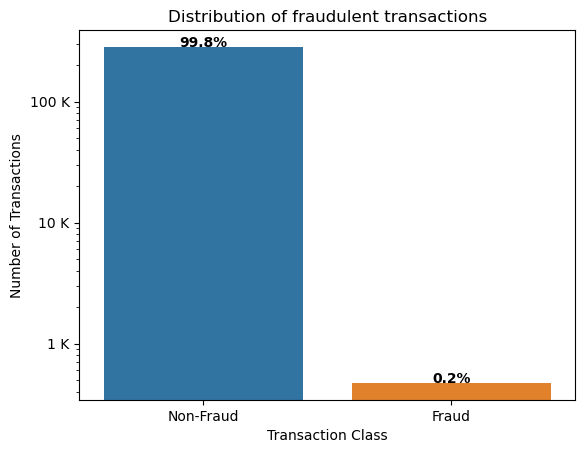

In [242]:
fraud_df = df.select("Class").toPandas()

# Count the number of transactions for each class (fraudulent or not)
fraud_counts = fraud_df['Class'].value_counts()

# Calculate the percentage of each class
fraud_perc = fraud_counts / fraud_counts.sum() * 100

# Create a bar plot with logarithmic y-axis
sns.barplot(x=fraud_counts.index, y=fraud_counts.values)
plt.yscale('log')

# Add percentage labels to the bars
for i, v in enumerate(fraud_counts):
    plt.text(i, v, f"{fraud_perc[i]:.1f}%", ha='center', fontweight='bold')

# Set the y-axis labels and formatter
plt.ylabel('Number of Transactions')
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0f} K'.format(x/1000)))

# Set the axis labels and title
plt.xlabel('Transaction Class')
plt.xticks([0, 1], ['Non-Fraud', 'Fraud'])
plt.title('Distribution of fraudulent transactions')

plt.show()

As previously said, most of the transactions are non-fraud. If we use this dataframe as the base for our predictive models and analysis we might get a lot of errors and our algorithms will probably overfit since it will "assume" that most transactions are not fraud. But we don't want our model to assume, we want our model to detect patterns that give signs of fraud!

## 1.3.2 Amount

In [243]:
# create a function to group time values
def udf_multi(time):
    if(time < 50000):
        return "Under 50K s"
    elif(time >= 50000 and time <= 100000):
        return "Between 50K and 100K s"
    elif(time > 100000):
        return "Over 100K s"
    else: return "NA"

In [244]:
# apply the function to the "Time column"
time_udf = f.udf(udf_multi)
df = df.withColumn('time_udf', time_udf('Time'))

df.limit(10).toPandas()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V22,V23,V24,V25,V26,V27,V28,Amount,Class,time_udf
0,26.0,-0.529912,0.873892,1.347247,0.145457,0.414209,0.100223,0.711206,0.176066,-0.286717,...,0.208105,-0.185548,0.001031,0.098816,-0.552904,-0.073288,0.023307,6.14,0,Under 50K s
1,158.0,-0.600816,0.922455,-0.135952,-1.259915,2.439824,3.330205,0.087107,0.949659,-0.327932,...,-0.927233,-0.045268,0.979587,0.016423,0.091043,0.371280,0.180187,1.79,0,Under 50K s
2,190.0,-1.505779,-0.215325,1.991294,-1.631493,-0.635965,0.228414,-0.034266,0.042696,-0.235440,...,0.148146,-0.450115,-0.396558,0.554224,-0.340493,-0.335618,-0.413379,82.29,0,Under 50K s
3,265.0,-0.491003,0.906953,1.645423,-0.083531,-0.195560,-0.710165,0.559119,0.116340,-0.538190,...,-0.517387,0.018650,0.491652,-0.277795,0.043841,0.253372,0.111749,9.03,0,Under 50K s
4,459.0,-0.528218,0.981232,1.652988,-0.150715,0.137048,-0.203980,0.583370,0.165246,-0.781696,...,-0.272731,0.023887,0.223936,-0.297777,0.068300,0.281018,0.111557,6.99,0,Under 50K s
5,775.0,-3.900810,-3.098370,-0.213428,-2.678434,-2.927576,0.735688,1.591471,-3.465433,1.812757,...,-0.097578,-4.020300,0.191246,-0.204492,-1.076721,1.072961,-0.188497,1528.90,0,Under 50K s
6,926.0,-1.536958,-0.041422,0.629846,-0.687015,0.796080,-0.485757,-0.302744,0.737427,-0.069131,...,-0.701171,-0.184521,-0.851564,-0.129501,0.345511,0.178534,-0.054153,1.00,0,Under 50K s
7,943.0,-1.212502,-0.058851,1.823435,-0.891164,-0.455972,1.330098,-0.631760,1.245756,0.774278,...,0.039612,0.233519,-0.621402,-0.463379,0.897888,-0.121907,-0.101759,48.94,0,Under 50K s
8,1261.0,-0.883529,1.173974,0.967298,1.125954,-0.518899,-1.139359,0.413262,0.136250,-0.666178,...,0.456075,-0.126655,0.940618,-0.078312,-0.353976,-0.275187,-0.038647,34.15,0,Under 50K s
9,1293.0,-1.434348,0.012470,3.327386,-0.738225,-0.630525,1.669713,-0.685391,0.674718,1.695032,...,0.965753,-0.342583,-0.157691,0.194028,1.204821,0.129031,-0.041771,8.00,0,Under 50K s


In [245]:
window = Window.rowsBetween(Window.unboundedPreceding, Window.unboundedFollowing)

In [246]:
# lets create a table
time_group_table = df.select(["time_udf", "Amount"]).\
                         groupBy('time_udf').\
                            agg(
                                f.count("Amount").alias("UserCount"),
                                f.mean("Amount").alias("Amount_Avg"),
                                f.min("Amount").alias("Amount_Min"),
                                f.max("Amount").alias("Amount_Max")).\
                            withColumn("total", f.sum(f.col("UserCount")).over(window)).\
                            withColumn("Percent", f.col("UserCount")*100 / f.col("total")).\
                            drop(f.col("total")).sort(f.desc("Percent"))

In [247]:
time_group_table.limit(10).toPandas()

,time_udf,UserCount,Amount_Avg,Amount_Min,Amount_Max,Percent
0,Over 100K s,130560,88.258712,0.0,25691.16,46.016227
1,Between 50K and 100K s,91602,83.923336,0.0,18910.00,32.285374
2,Under 50K s,61564,95.695518,0.0,19656.53,21.698399


Here we computed some statistics with the "Amount" column, divided by the three time groups defined earlier. Now let's plot our results:

<Axes: xlabel='time_udf', ylabel='Percent'>

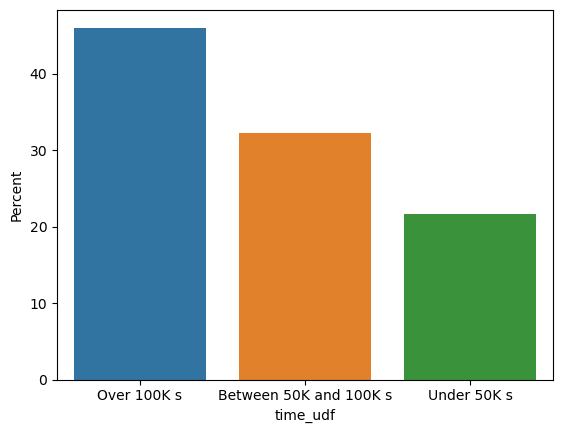

In [248]:
sns.barplot(x="time_udf", y="Percent", data=time_group_table.toPandas())

After analysing the graph, we conclude that the largest percentage for the Amount values is found when the time between each transaction recorded is over 100 000 seconds.

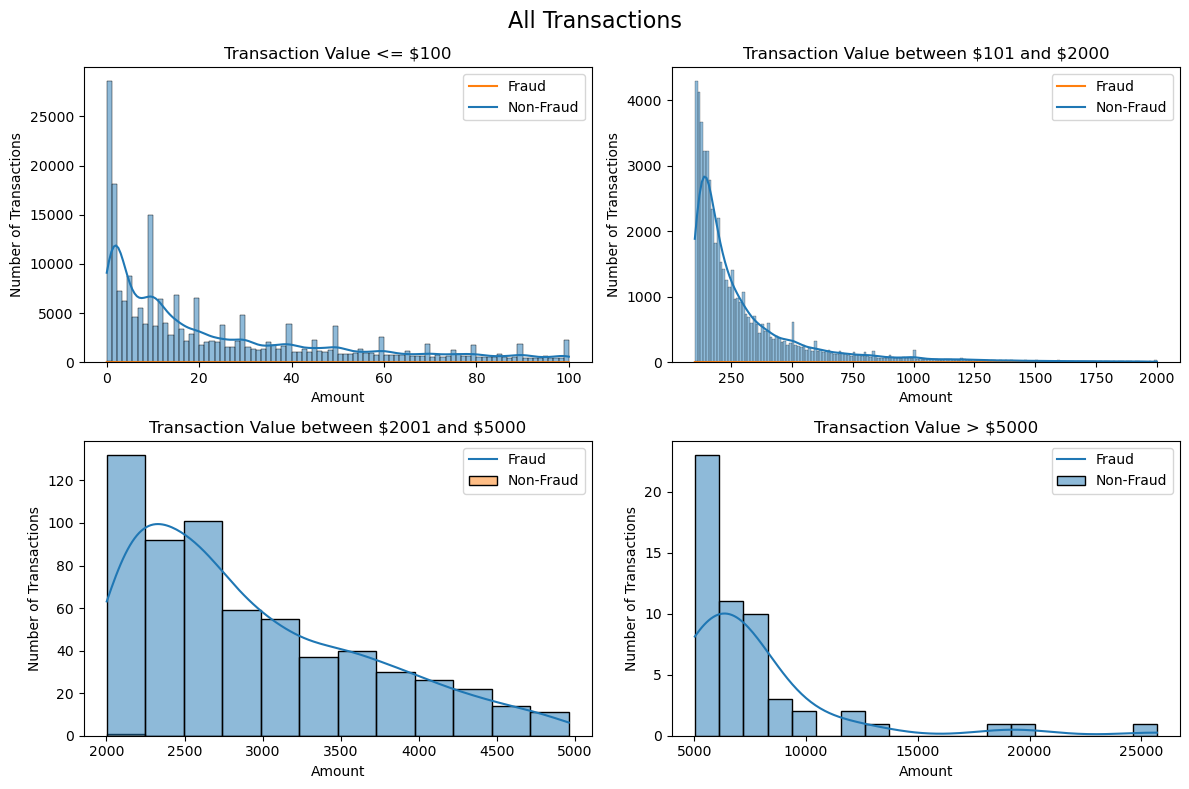

In [249]:
# All Transactions
df_aux = df.select("Class", "Amount").toPandas()

# Define amount ranges
amount_ranges = [
    {"range": "Transaction Value <= $100", "min_amount": 0, "max_amount": 100},
    {"range": "Transaction Value between \$101 and \$2000", "min_amount": 101, "max_amount": 2000},
    {"range": "Transaction Value between \$2001 and \$5000", "min_amount": 2001, "max_amount": 5000},
    {"range": "Transaction Value > $5000", "min_amount": 5001, "max_amount": df_aux["Amount"].max()}
]

# Create four subplots for different amount ranges
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

for idx, amount_range in enumerate(amount_ranges):
    row_idx = idx // 2
    col_idx = idx % 2

    # Filter transactions within amount range
    df_range = df_aux[(df_aux["Amount"] > amount_range["min_amount"]) & (df_aux["Amount"] <= amount_range["max_amount"])]

    # Plot histogram
    sns.histplot(data=df_range, x="Amount", ax=axes[row_idx, col_idx], hue="Class", kde=True)
    axes[row_idx, col_idx].set_title(amount_range["range"])
    axes[row_idx, col_idx].set_ylabel("Number of Transactions")
    axes[row_idx, col_idx].legend(labels=["Fraud", "Non-Fraud"])

fig.suptitle("All Transactions", fontsize=16)
plt.tight_layout()
plt.show()

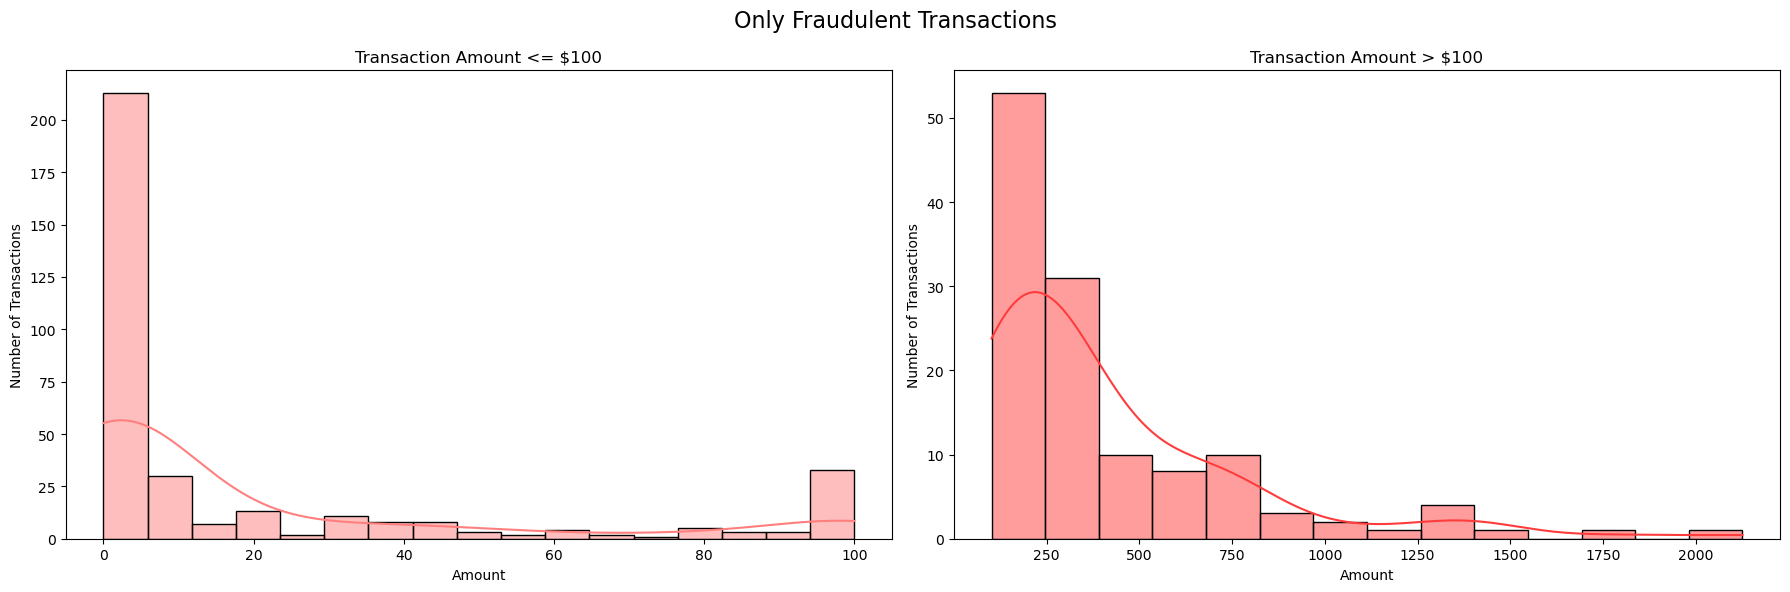

In [250]:
# Only fraud transactions
only_fraud = df.filter(df.Class == 1).select("Amount").toPandas()

# Add a pallet
aux_pal = ["#ff7f7f", "#ff3c3c"]

# Create three subplots for different amount ranges
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

# Amount range <= 100
sns.histplot(data=only_fraud[only_fraud["Amount"] <= 100], x="Amount", ax=axes[0], kde=True, color=aux_pal[0])
axes[0].set_title("Transaction Amount <= $100")
axes[0].set_ylabel("Number of Transactions")

# Amount range > 100
sns.histplot(data=only_fraud[(only_fraud["Amount"] > 100)], x="Amount", ax=axes[1], kde=True, color=aux_pal[1])
axes[1].set_title("Transaction Amount > $100")
axes[1].set_ylabel("Number of Transactions")

fig.suptitle("Only Fraudulent Transactions", fontsize=16)
plt.tight_layout()
plt.show()

## 1.3.3 Remaining variables

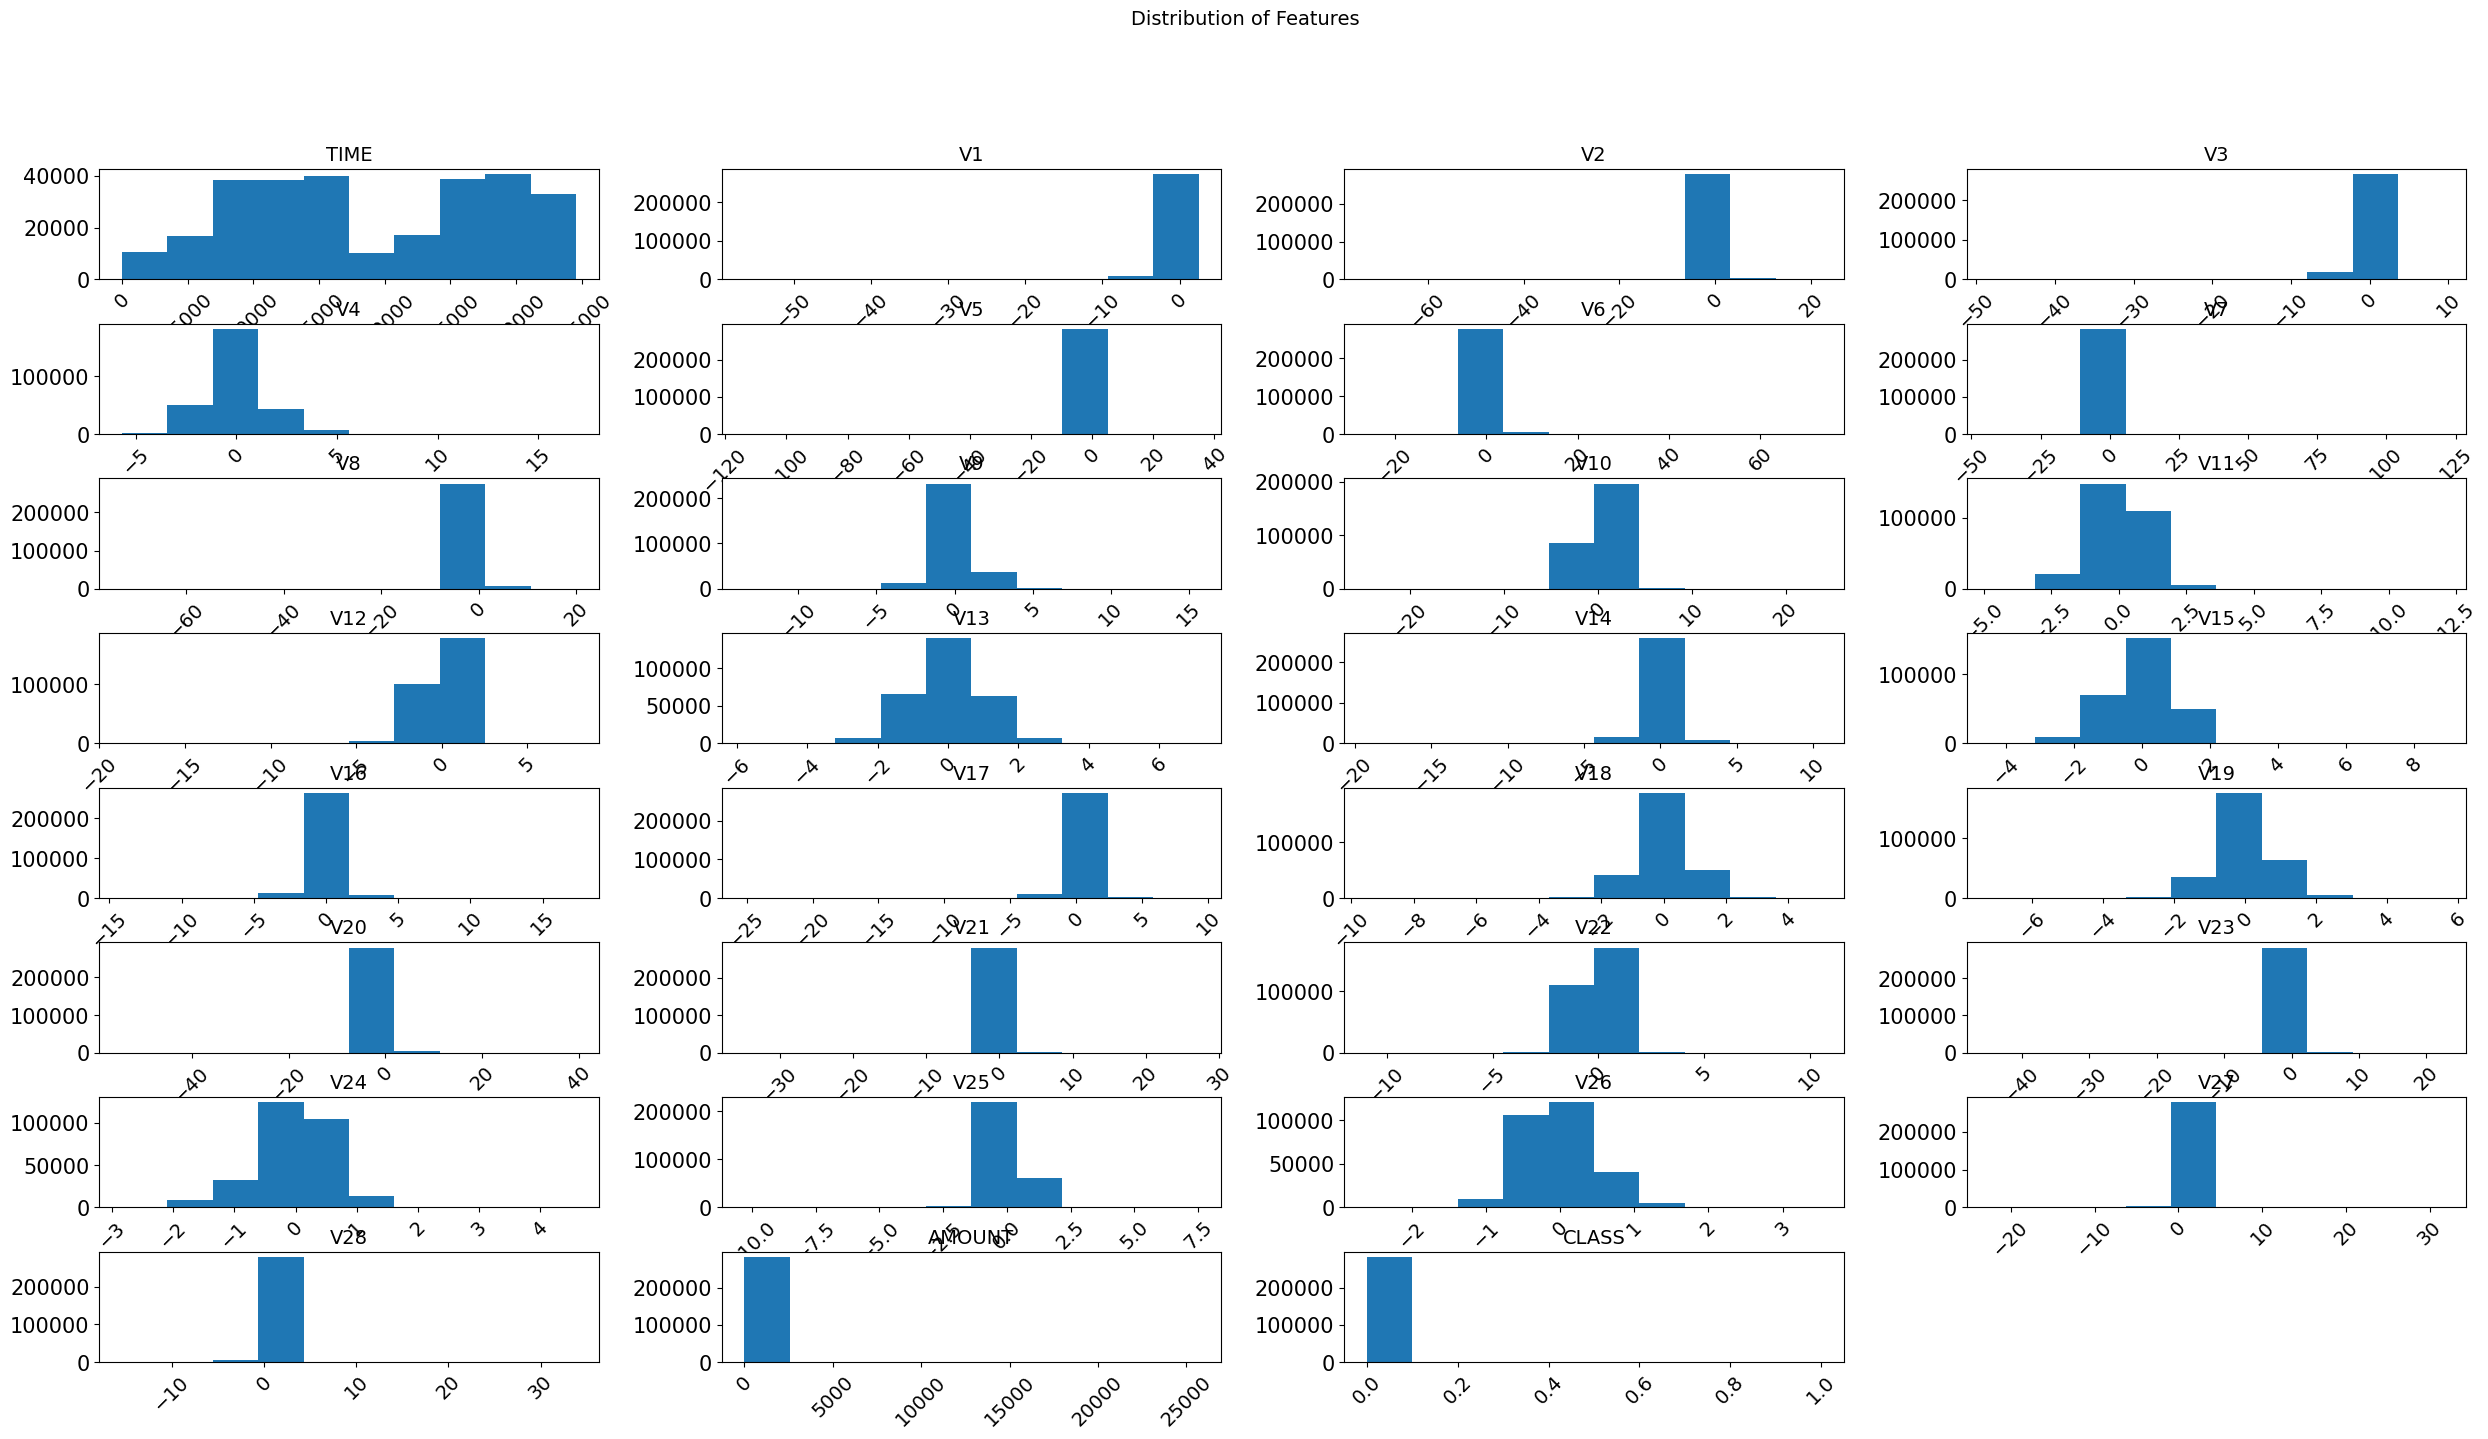

In [251]:
# create several histograms to show the distributions of the features
fig = plt.figure(figsize=(25, 15))
subtitle = fig.suptitle("Distribution of Features", fontsize=14, verticalalignment="center")
for col, num in zip(df.toPandas().describe().columns, range(1, 32)):
    ax = fig.add_subplot(8, 4, num)
    ax.hist(df.toPandas()[col])
    plt.grid(False)
    plt.xticks(rotation=45, fontsize=14)
    plt.yticks(fontsize=15)
    plt.title(col.upper(), fontsize=14)
plt.tight_layout()
subtitle.set_y(0.95)
fig.subplots_adjust(top=0.85, hspace=0.4)
plt.show()


By analysing these plots, we conclude that Time does not have a normal distribution and the values 75 000-100 000 seconds are the ones with less occurences throughout the dataset. All of the Vx componentes are normalized, and with most occurences centered around the value 0. These feautures also show some negative values.

## 1.4 Normalization

In this phase of our kernel, we will first scale the columns comprise of Time and Amount. Time and amount should be scaled as the other columns.

## 1.5 Outliers

## 1.6 Imbalanced data

In this phase of the project we will implement "Random Under Sampling" which basically consists of removing data in order to have a more balanced dataset and thus avoiding our models to overfitting.

Steps:

    1) The first thing we have to do is determine how imbalanced is our class (use "value_counts()" on the class column to determine the amount for each label)
    2) Once we determine how many instances are considered fraud transactions (Fraud = "1") , we should bring the non-fraud transactions to the same amount as fraud transactions (assuming we want a 50/50 ratio), this will be equivalent to 492 cases of fraud and 492 cases of non-fraud transactions.
    3) After implementing this technique, we have a sub-sample of our dataframe with a 50/50 ratio with regards to our classes. Then the next step we will implement is to shuffle the data to see if our models can maintain a certain accuracy everytime we run this script.
    
Note: The main issue with "Random Under-Sampling" is that we run the risk that our classification models will not perform as accurate as we would like to since there is a great deal of information loss (bringing 492 non-fraud transaction from 284,315 non-fraud transaction)

However, Using the original dataframe will cause the following issues:

    Overfitting: Our classification models will assume that in most cases there are no frauds! What we want for our model is to be certain when a fraud occurs.
    Wrong Correlations: Although we don't know what the "V" features stand for, it will be useful to understand how each of this features influence the result (Fraud or No Fraud) by having an imbalance dataframe we are not able to see the true correlations between the class and features.

In [252]:
fraud_df = df.filter(f.col('Class') == 1)
non_fraud_df = df.filter(f.col('Class') == 0).limit(fraud_df.count())
normal_distributed_df = fraud_df.union(non_fraud_df)

normal_distributed_df_shuffle = normal_distributed_df.orderBy(f.rand())
normal_distributed_df_shuffle.limit(10).toPandas()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V22,V23,V24,V25,V26,V27,V28,Amount,Class,time_udf
0,59385.0,-7.626924,-6.976420,-2.077911,3.416754,4.458758,-5.080408,-6.578948,1.760341,-0.599509,...,-0.656639,-0.330811,-0.078946,0.270306,0.431119,0.821381,-1.056088,18.98,1,Between 50K and 100K s
1,5581.0,1.164207,-0.851953,0.616513,-0.297988,-1.081345,-0.102173,-0.828929,0.088774,0.775880,...,-0.045334,-0.021019,0.166528,0.330513,-0.286032,-0.022243,0.004079,77.69,0,Under 50K s
2,11080.0,-2.125490,5.973556,-11.034727,9.007147,-1.689451,-2.854415,-7.810441,2.030870,-5.902828,...,-0.278485,-0.664841,-1.164555,1.701796,0.690806,2.119749,1.108933,1.00,1,Under 50K s
3,160243.0,-2.783865,1.596824,-2.084844,2.512986,-1.446749,-0.828496,-0.732262,-0.203329,-0.347046,...,0.293268,0.199568,0.146868,0.163602,-0.624085,-1.333100,0.428634,156.00,1,Over 100K s
4,17471.0,-0.897681,-0.783208,1.450300,-1.876179,-0.450268,2.150076,0.255096,0.633616,2.318280,...,1.102641,0.451759,-1.355874,-0.167029,0.158369,0.019536,0.014787,260.00,0,Under 50K s
5,51165.0,-0.460809,-0.106135,0.860763,-1.581086,0.896769,1.048579,0.340497,0.160700,-1.755249,...,1.305796,-0.023751,-0.975052,0.025090,-0.045976,-0.199957,-0.269162,15.00,0,Between 50K and 100K s
6,31772.0,-0.610858,0.841679,1.383381,0.128666,0.431677,-0.603175,0.928020,0.100537,-0.392727,...,-1.220904,0.208146,-0.070215,-0.541049,-1.006836,0.110001,0.143350,23.73,0,Under 50K s
7,59206.0,1.201550,-0.104541,0.673090,0.963770,-0.086544,1.080701,-0.641072,0.300104,0.934344,...,-0.092177,-0.154846,-1.308755,0.538642,-0.294189,0.088554,0.022056,12.99,0,Between 50K and 100K s
8,53865.0,-0.797122,0.384724,0.584407,-1.514798,-0.329098,-1.187837,-0.335764,0.362465,-1.288079,...,0.145943,-0.085120,-0.044488,0.086317,-0.425914,0.159592,-0.021589,15.90,0,Between 50K and 100K s
9,34328.0,-0.608579,1.260305,0.828699,0.859959,0.296304,0.532987,1.003295,0.000979,-0.527669,...,0.619827,-0.222624,-0.717449,0.006437,-0.116170,0.588066,0.240379,95.00,0,Under 50K s


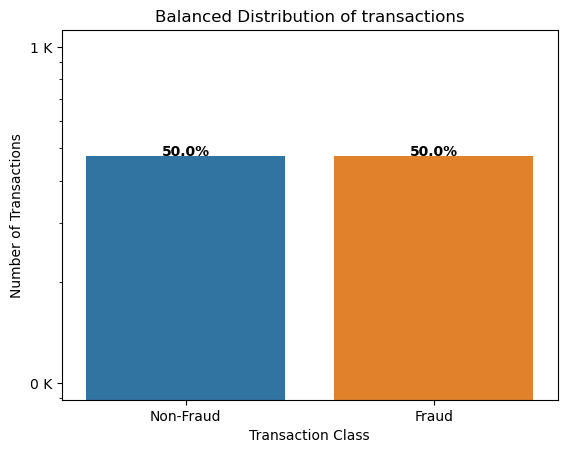

In [253]:
fraud_df = normal_distributed_df_shuffle.select("Class").toPandas()

# Count the number of transactions for each class (fraudulent or not)
fraud_counts = fraud_df['Class'].value_counts()

# Calculate the percentage of each class
fraud_perc = fraud_counts / fraud_counts.sum() * 100

# Create a bar plot with logarithmic y-axis
sns.barplot(x=fraud_counts.index, y=fraud_counts.values)
plt.yscale('log')

# Add percentage labels to the bars
for i, v in enumerate(fraud_counts):
    plt.text(i, v, f"{fraud_perc[i]:.1f}%", ha='center', fontweight='bold')

# Set the y-axis labels and formatter
plt.ylabel('Number of Transactions')
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0f} K'.format(x/1000)))

# Set the axis labels and title
plt.xlabel('Transaction Class')
plt.xticks([0, 1], ['Non-Fraud', 'Fraud'])
plt.title('Balanced Distribution of transactions')

plt.show()

Now that we have our dataframe correctly balanced, we can go further with our analysis and data preprocessing.

## Correlations

Correlation matrices are the essence of understanding our data. We want to know if there are features that influence heavily in whether a specific transaction is a fraud. However, it is important that we use the correct dataframe (Balanced) in order for us to see which features have a high positive or negative correlation with regards to fraud transactions.

Summary and Explanation:

    Negative Correlations: V17, V14, V12 and V10 are negatively correlated. Notice how the lower these values are, the more likely the end result will be a fraud transaction.
    Positive Correlations: V2, V4, V11, and V19 are positively correlated. Notice how the higher these values are, the more likely the end result will be a fraud transaction.
    BoxPlots: We will use boxplots to have a better understanding of the distribution of these features in fradulent and non fradulent transactions.
    
Note: We have to make sure we use the subsample in our correlation matrix or else our correlation matrix will be affected by the high imbalance between our classes. This occurs due to the high class imbalance in the original dataframe.

In [254]:
df = df.drop("time_udf")

<function matplotlib.pyplot.show(close=None, block=None)>

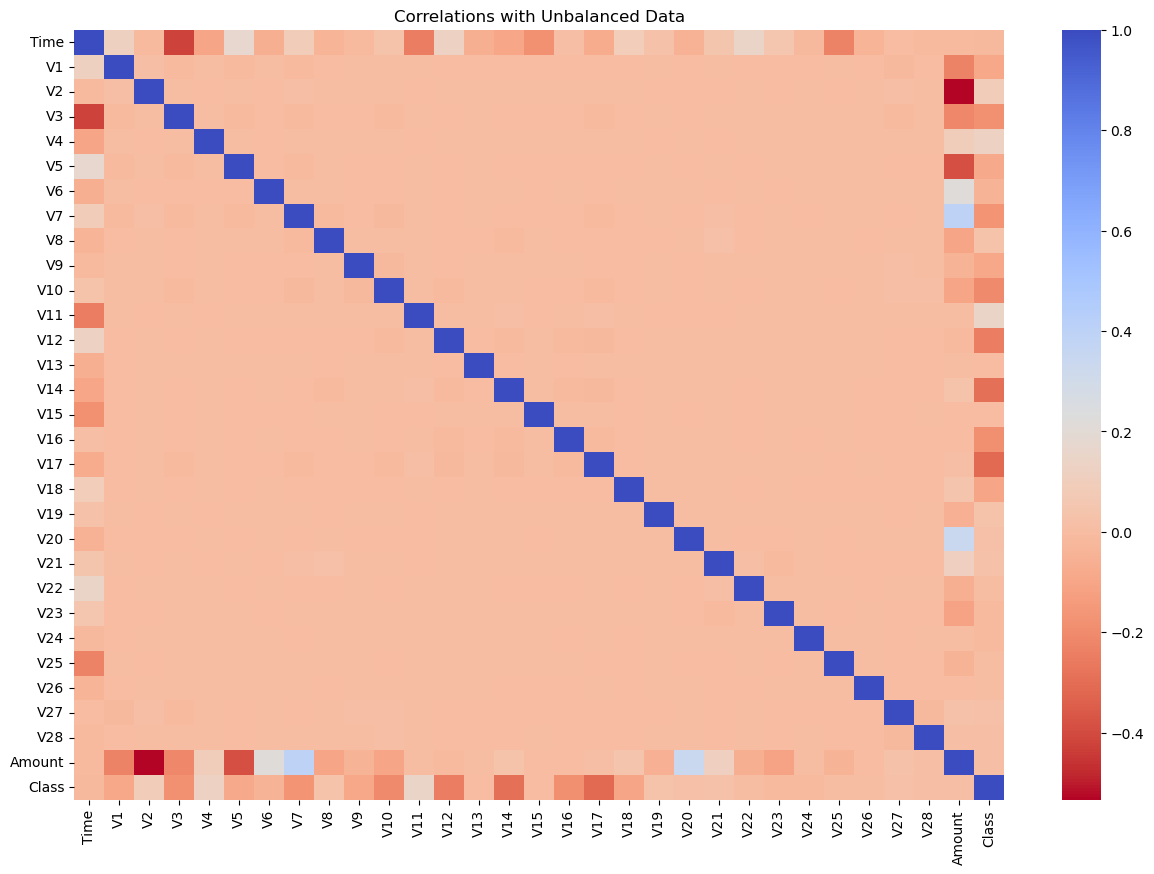

In [255]:
plt.figure(figsize=(15, 10))
sns.heatmap(df.toPandas().corr(),cmap='coolwarm_r')
plt.title('Correlations with Unbalanced Data')
plt.show

In [256]:
normal_distributed_df_shuffle = normal_distributed_df_shuffle.drop("time_udf")

<function matplotlib.pyplot.show(close=None, block=None)>

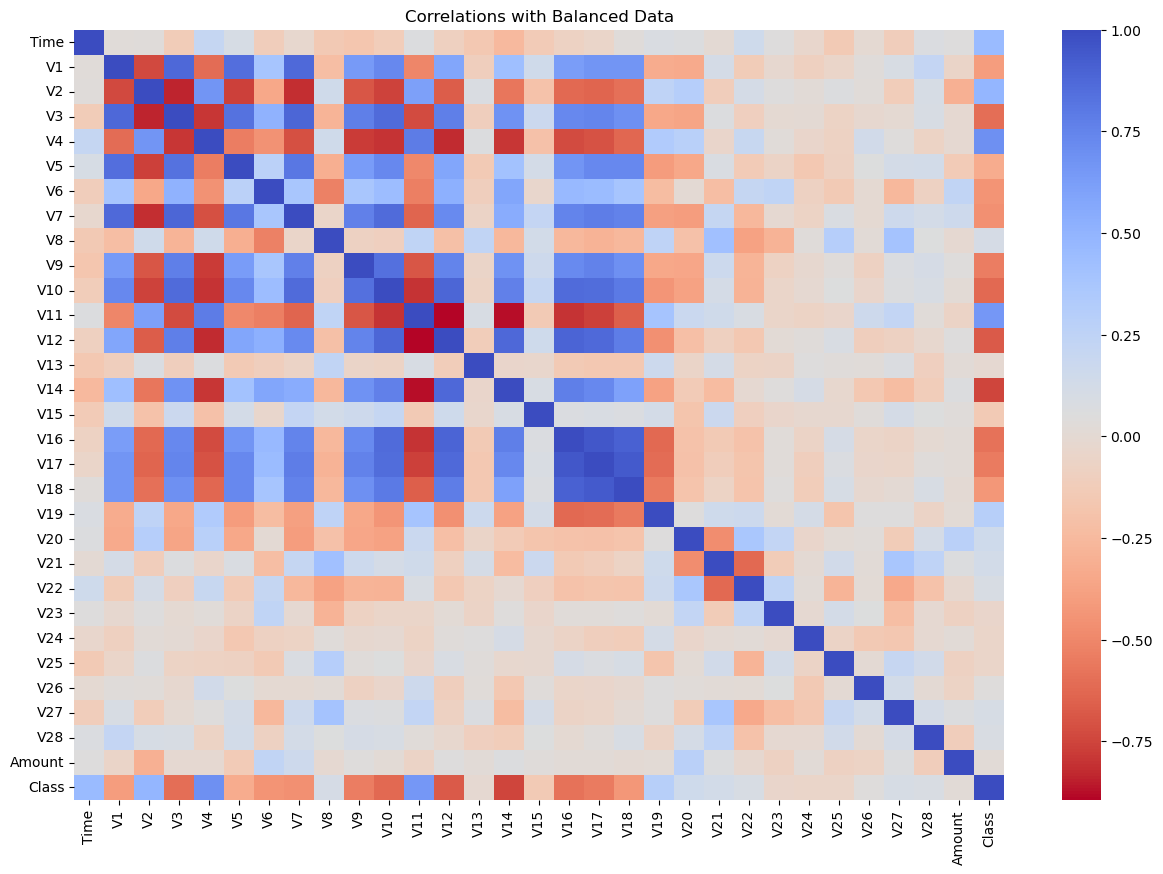

In [257]:
plt.figure(figsize=(15, 10))
sns.heatmap(normal_distributed_df_shuffle.toPandas().corr(),cmap='coolwarm_r')
plt.title('Correlations with Balanced Data')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

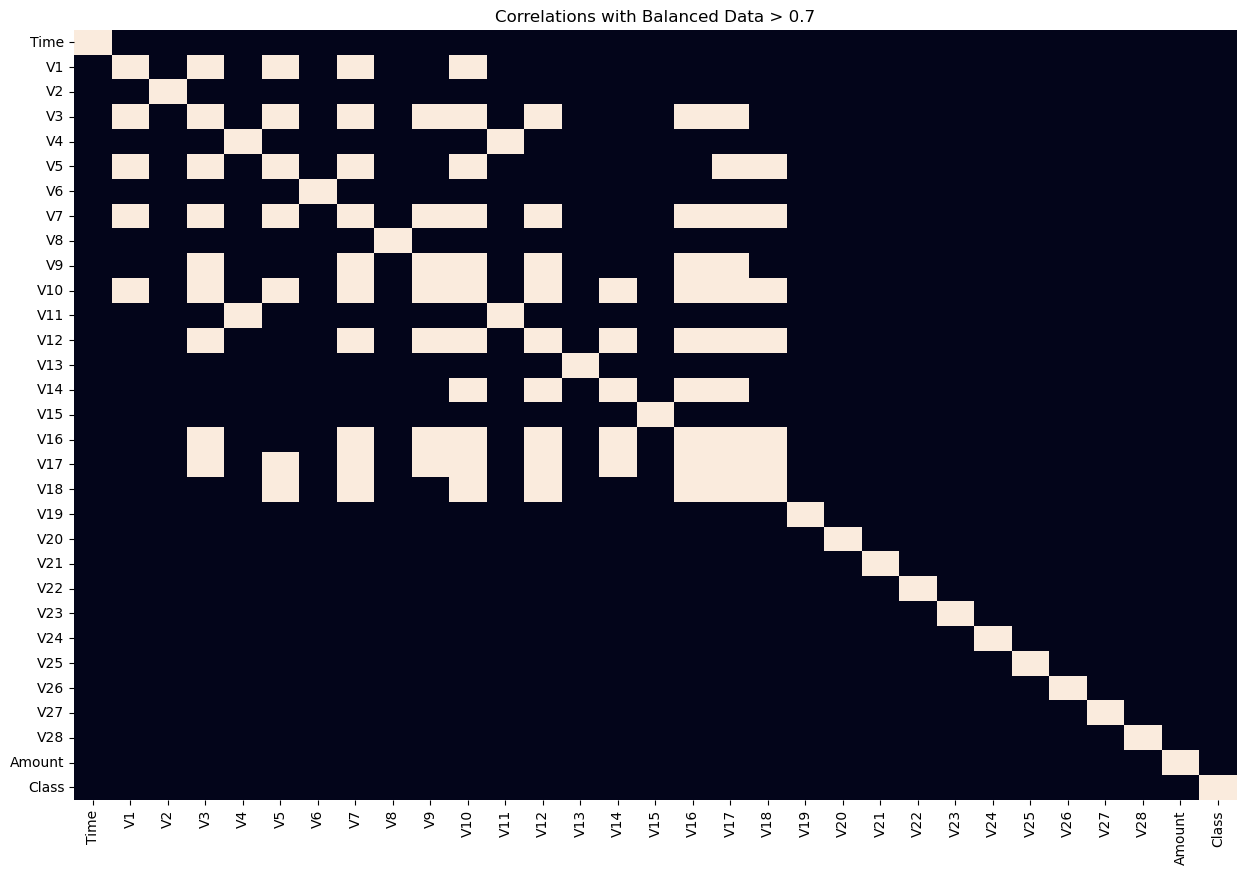

In [258]:
plt.figure(figsize=(15, 10))
sns.heatmap(normal_distributed_df_shuffle.toPandas().corr() > 0.7,cbar=False, annot_kws={'size':20})
plt.title('Correlations with Balanced Data > 0.7')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

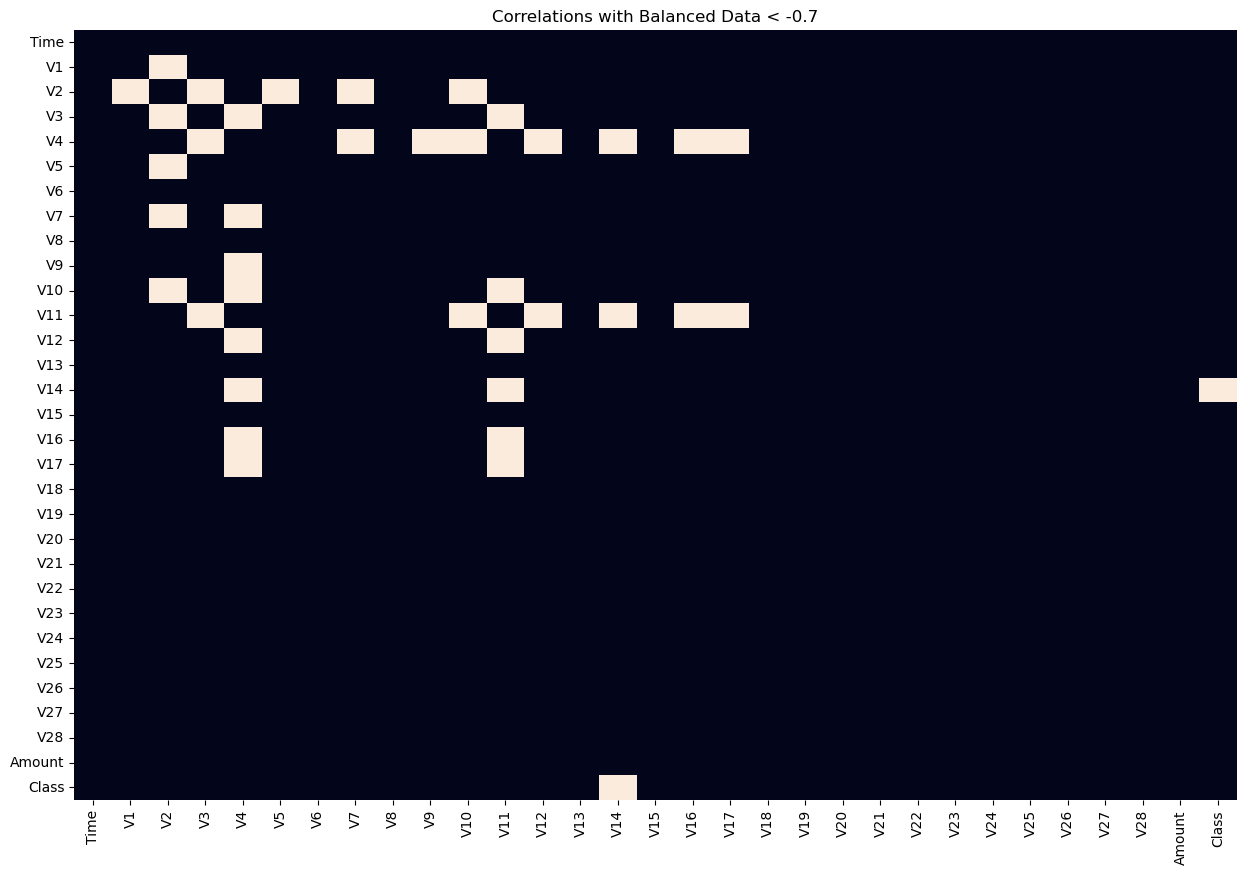

In [259]:
plt.figure(figsize=(15, 10))
sns.heatmap(normal_distributed_df_shuffle.toPandas().corr() < -0.7,cbar=False, annot_kws={'size':20})
plt.title('Correlations with Balanced Data < -0.7')
plt.show

By looking at our correlation matrix, we arrived at the following conclusions:

    The variables that were a product of PCA are not correlated with each other;
    "Time" seems to be negatively correlated with all of the "Vx" variables;
    "Time" and "Class" seem to have no correlation;
    "Class" seem to be negatively correlated with some of the "Vx" variables, and not correlated at all with others.

## Distributions: Univariate

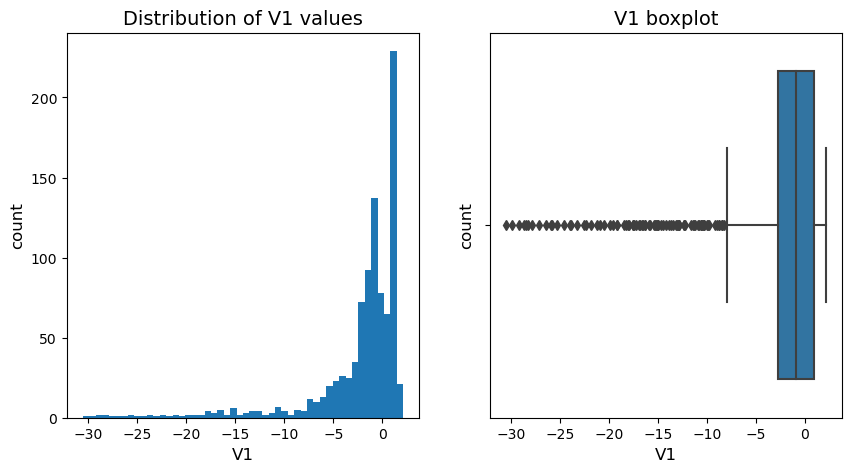

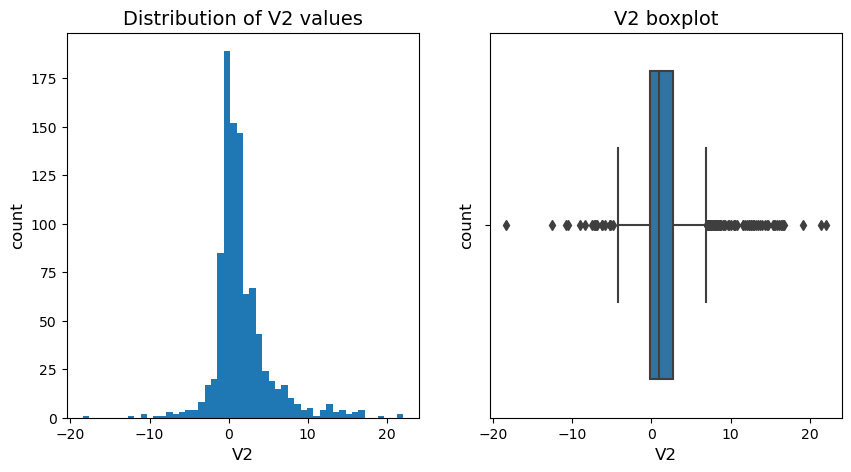

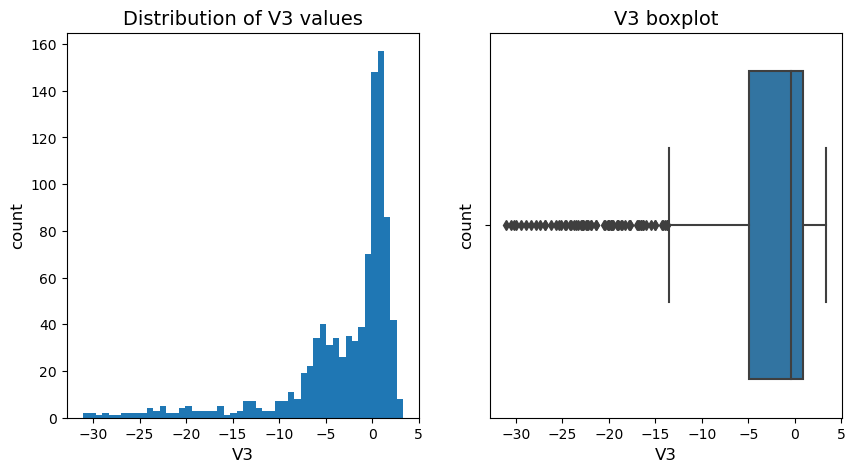

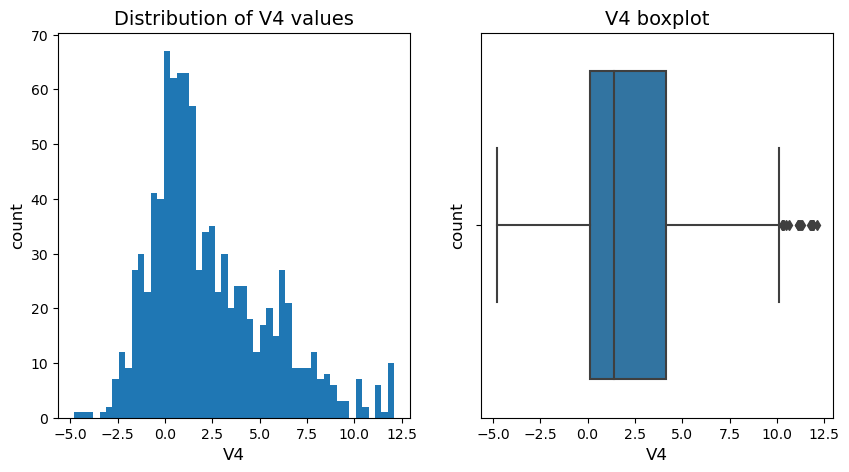

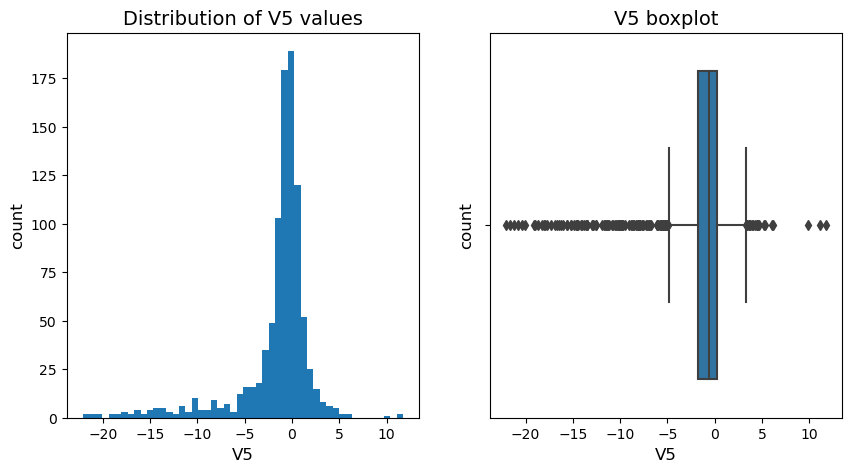

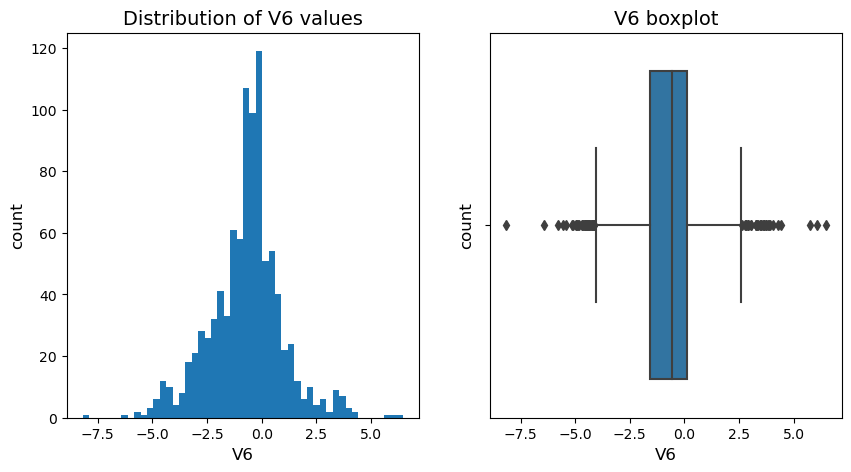

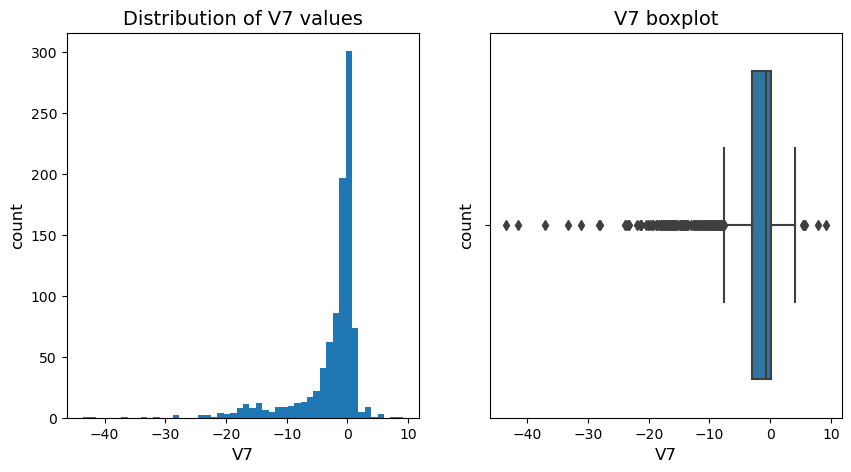

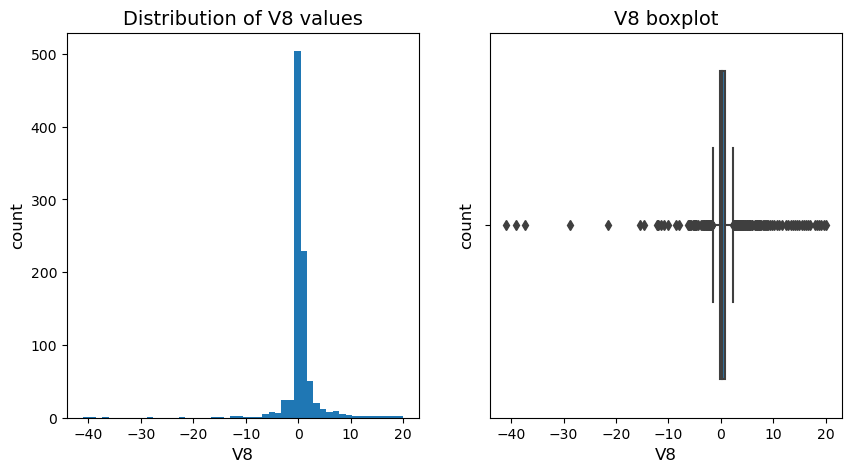

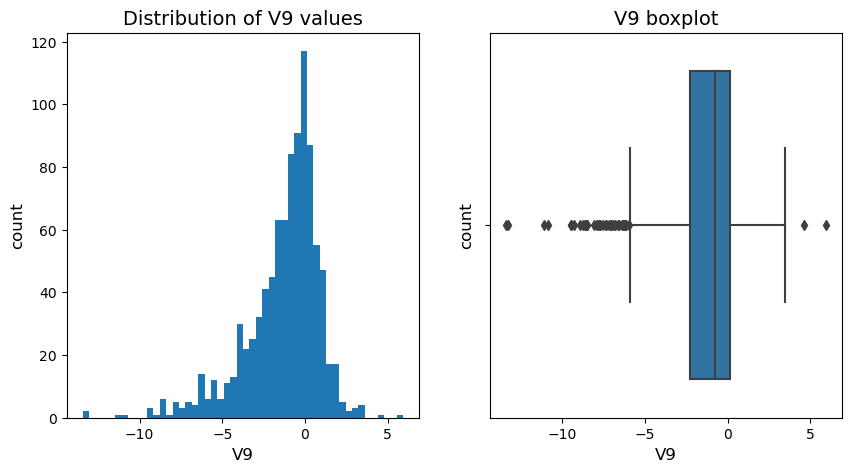

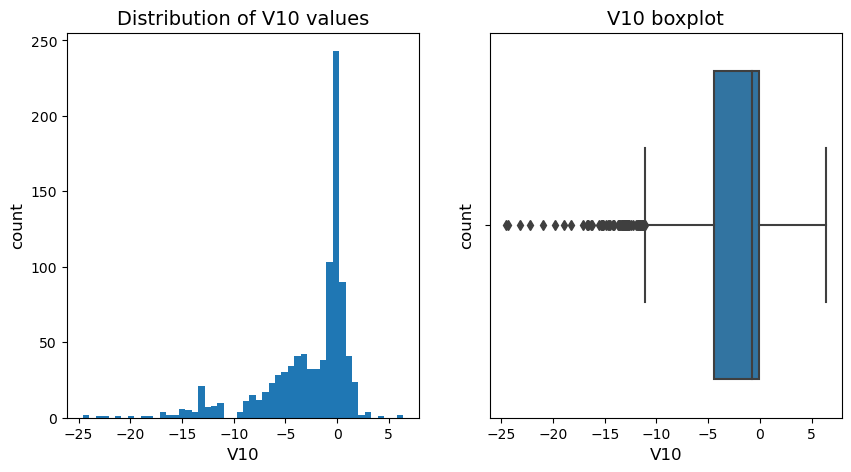

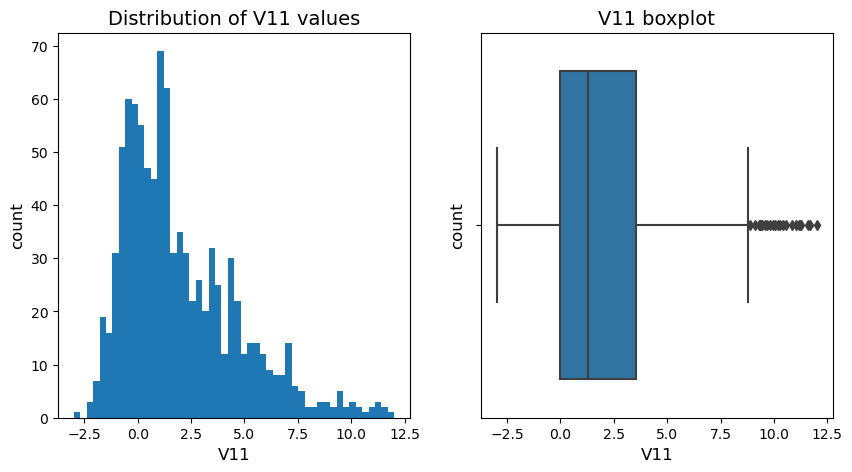

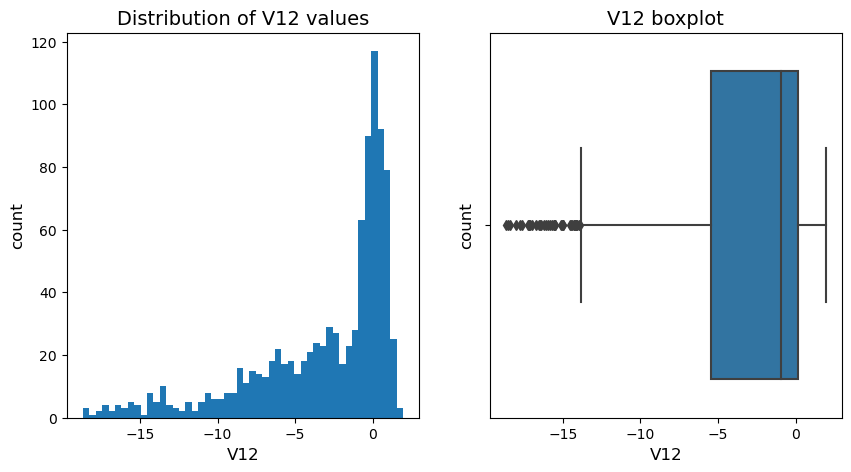

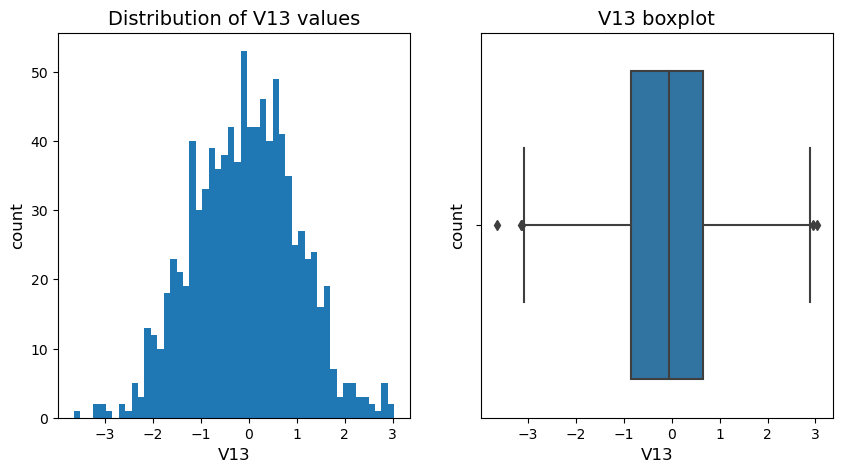

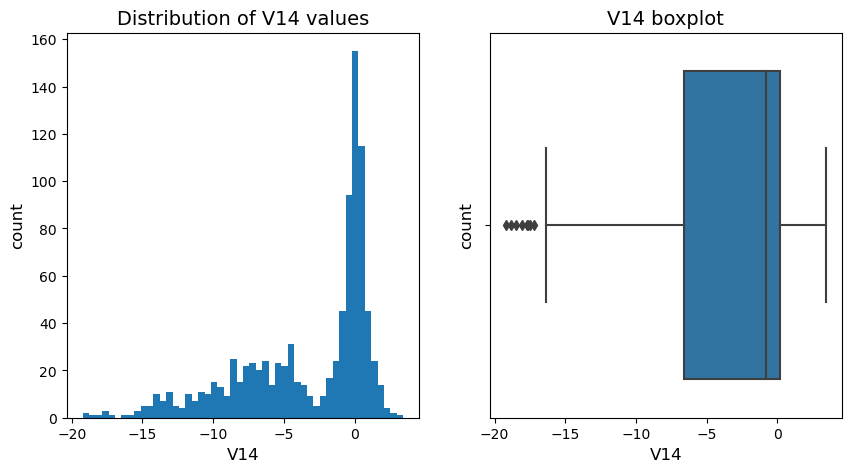

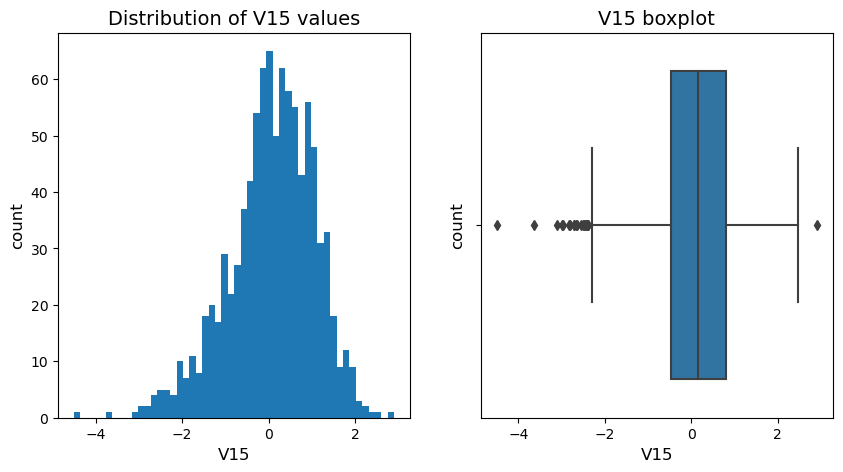

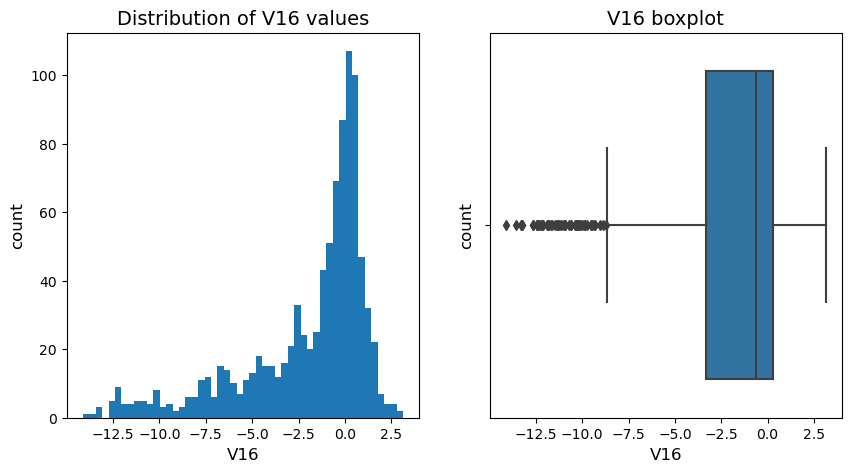

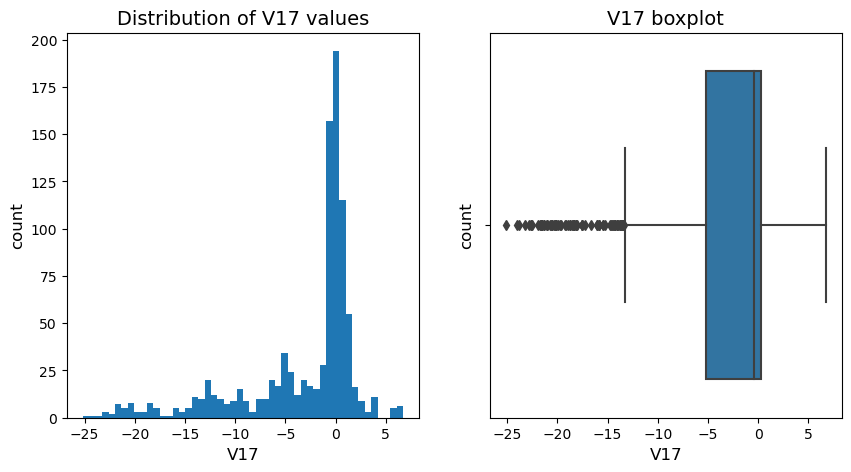

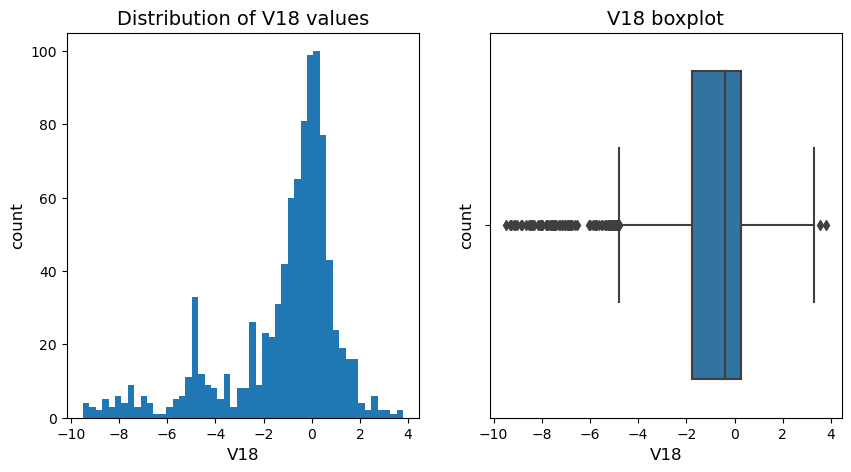

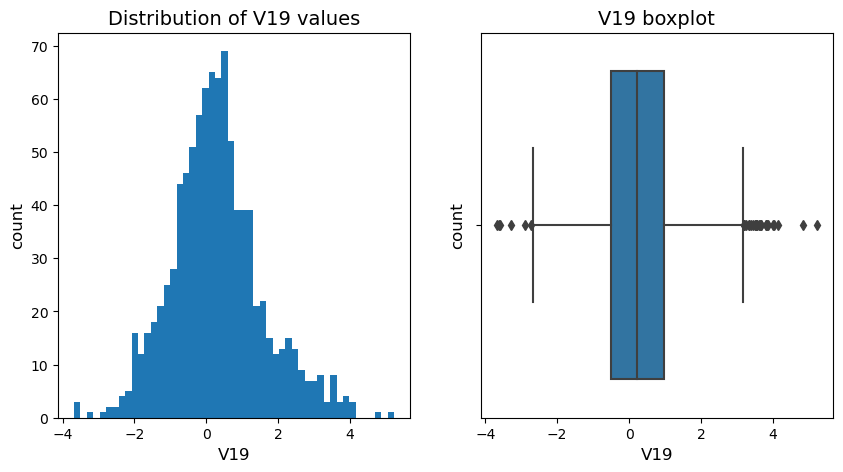

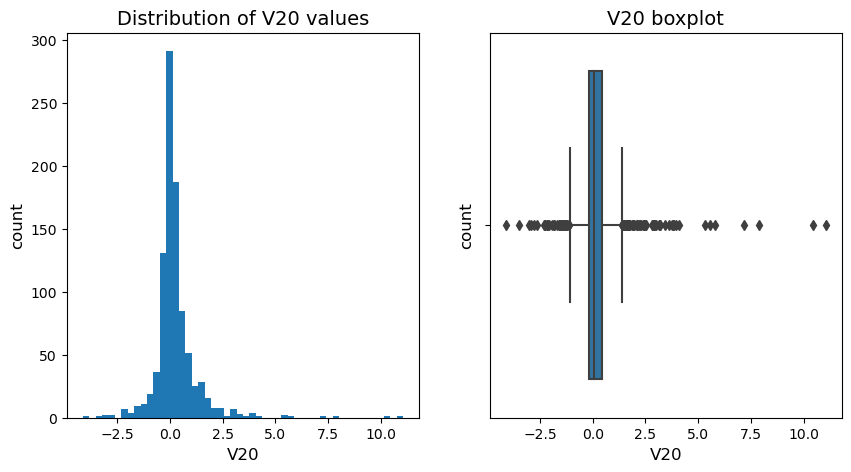

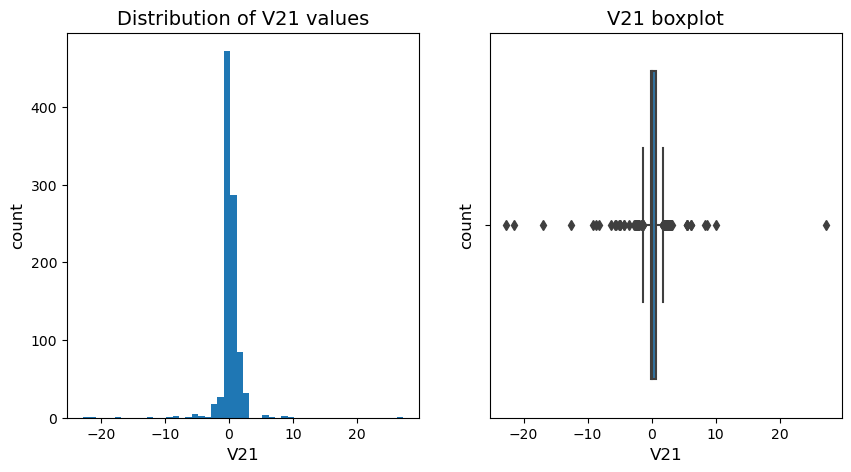

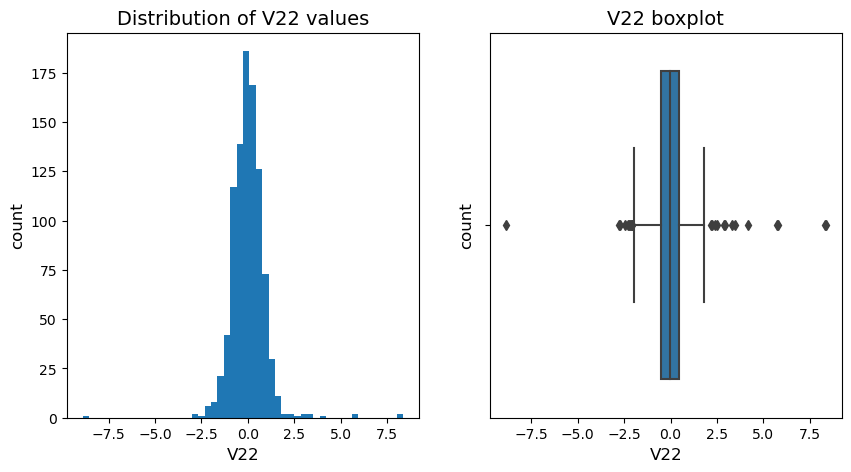

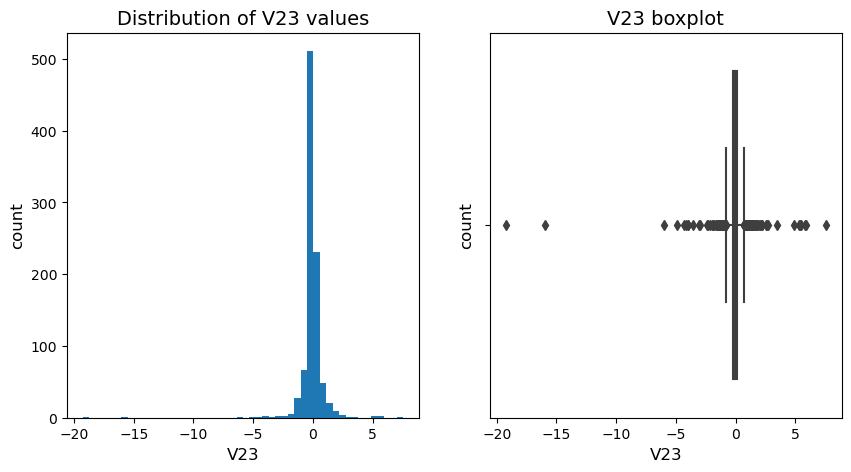

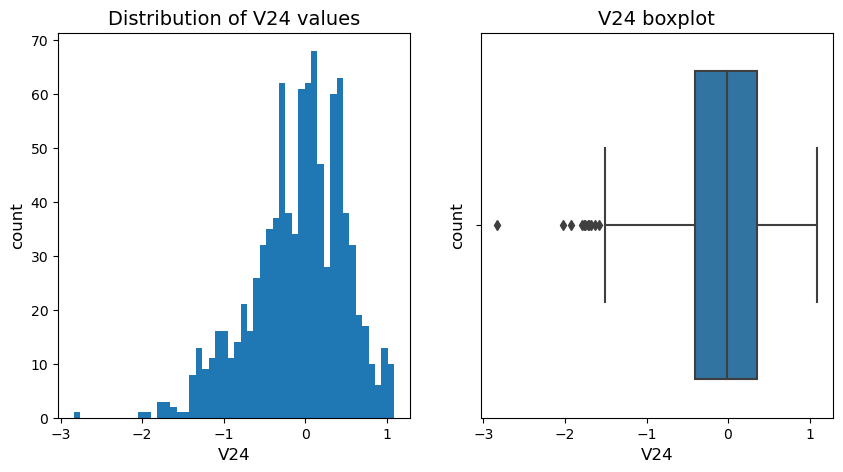

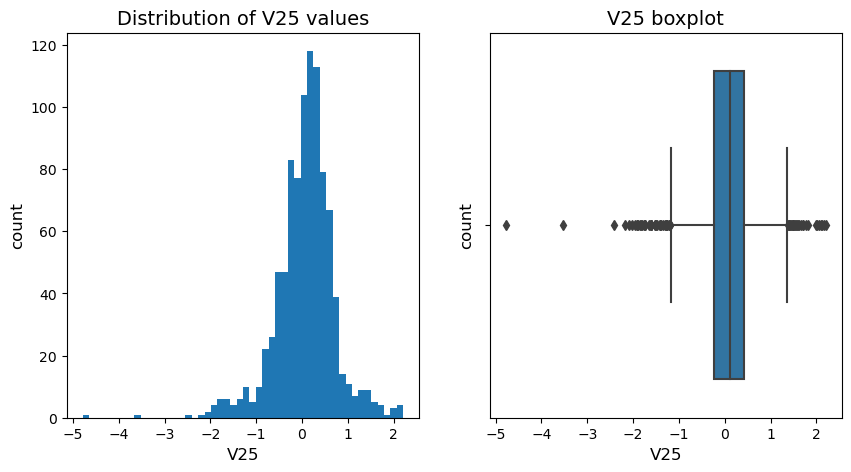

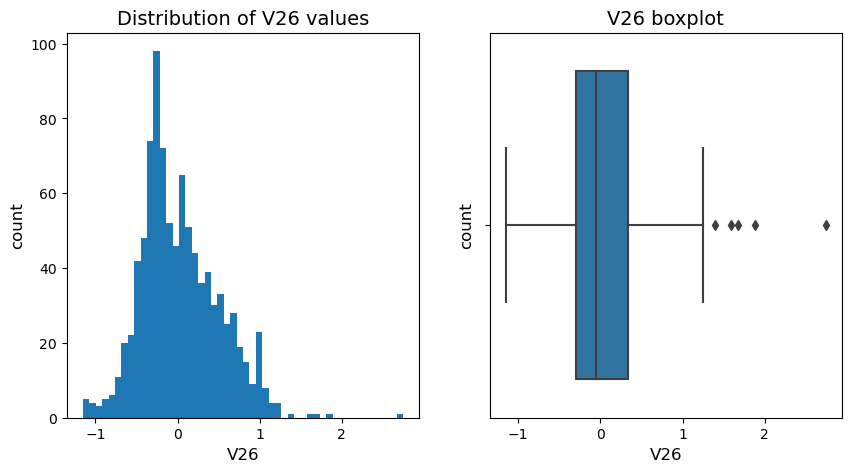

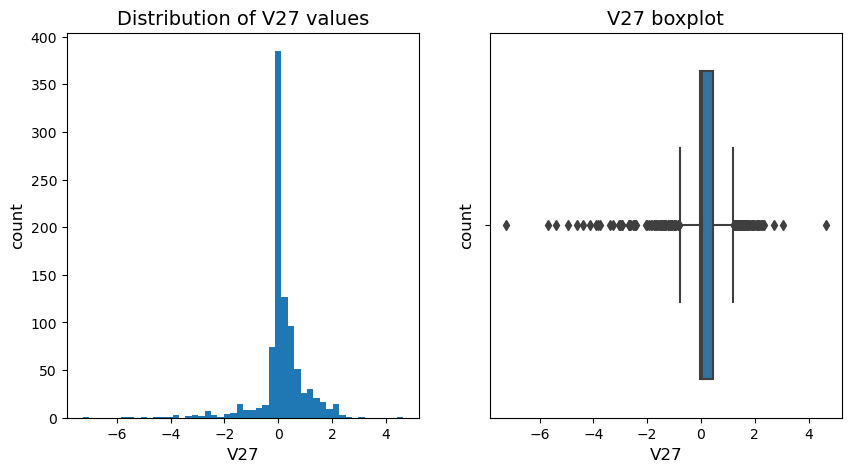

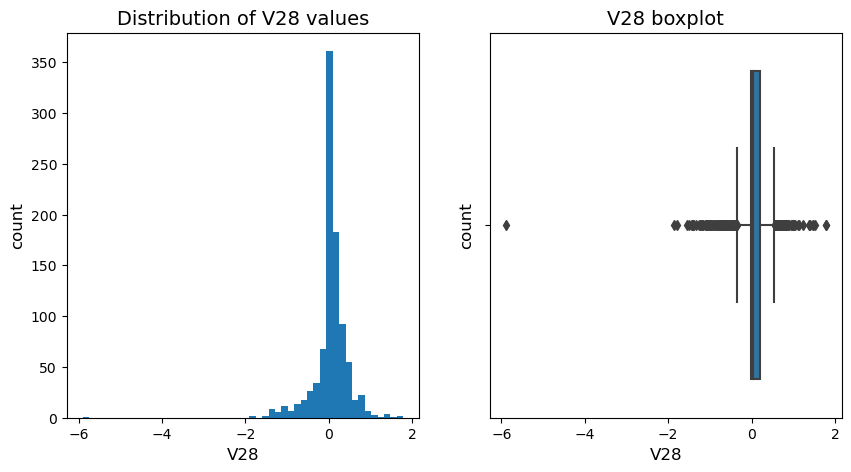

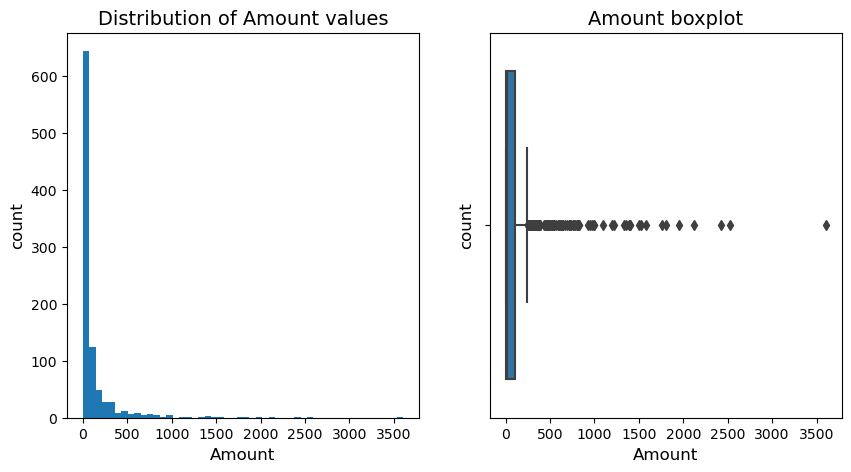

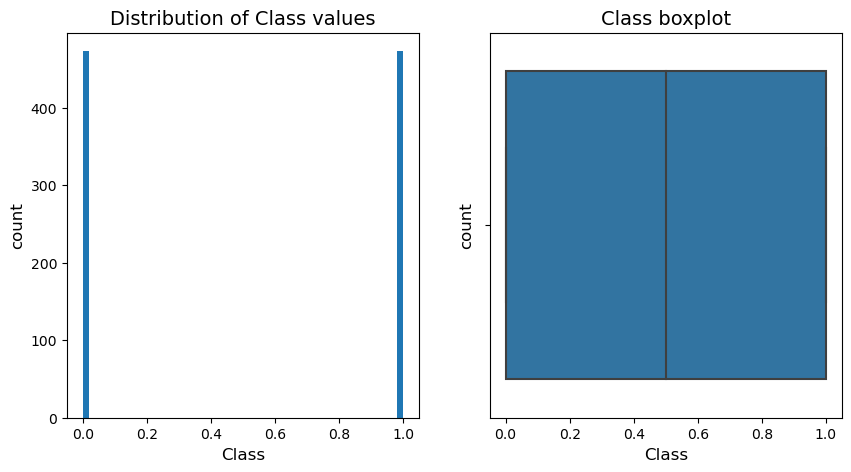

In [260]:
# select all columns except the ones to exclude
cols_to_include = [col for col in normal_distributed_df_shuffle.columns if col not in ['Time']]
df_to_plot = normal_distributed_df_shuffle.select(*cols_to_include)

# loop over each column and plot a histogram
for col in df_to_plot.columns:
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.hist(df_to_plot.select(col).rdd.flatMap(lambda x: x).collect(), bins=50)
    plt.title(f"Distribution of {col} values", size=14)
    plt.xlabel(col, size=12)
    plt.ylabel("count", size=12)

    plt.subplot(1,2,2)
    sns.boxplot(data=df_to_plot.select(col).toPandas(), x = col)
    plt.title('{} boxplot'.format(col) , size = 14)
    plt.xlabel(col , size = 12)
    plt.ylabel("count", size = 12)


## Distributions: Bivariate

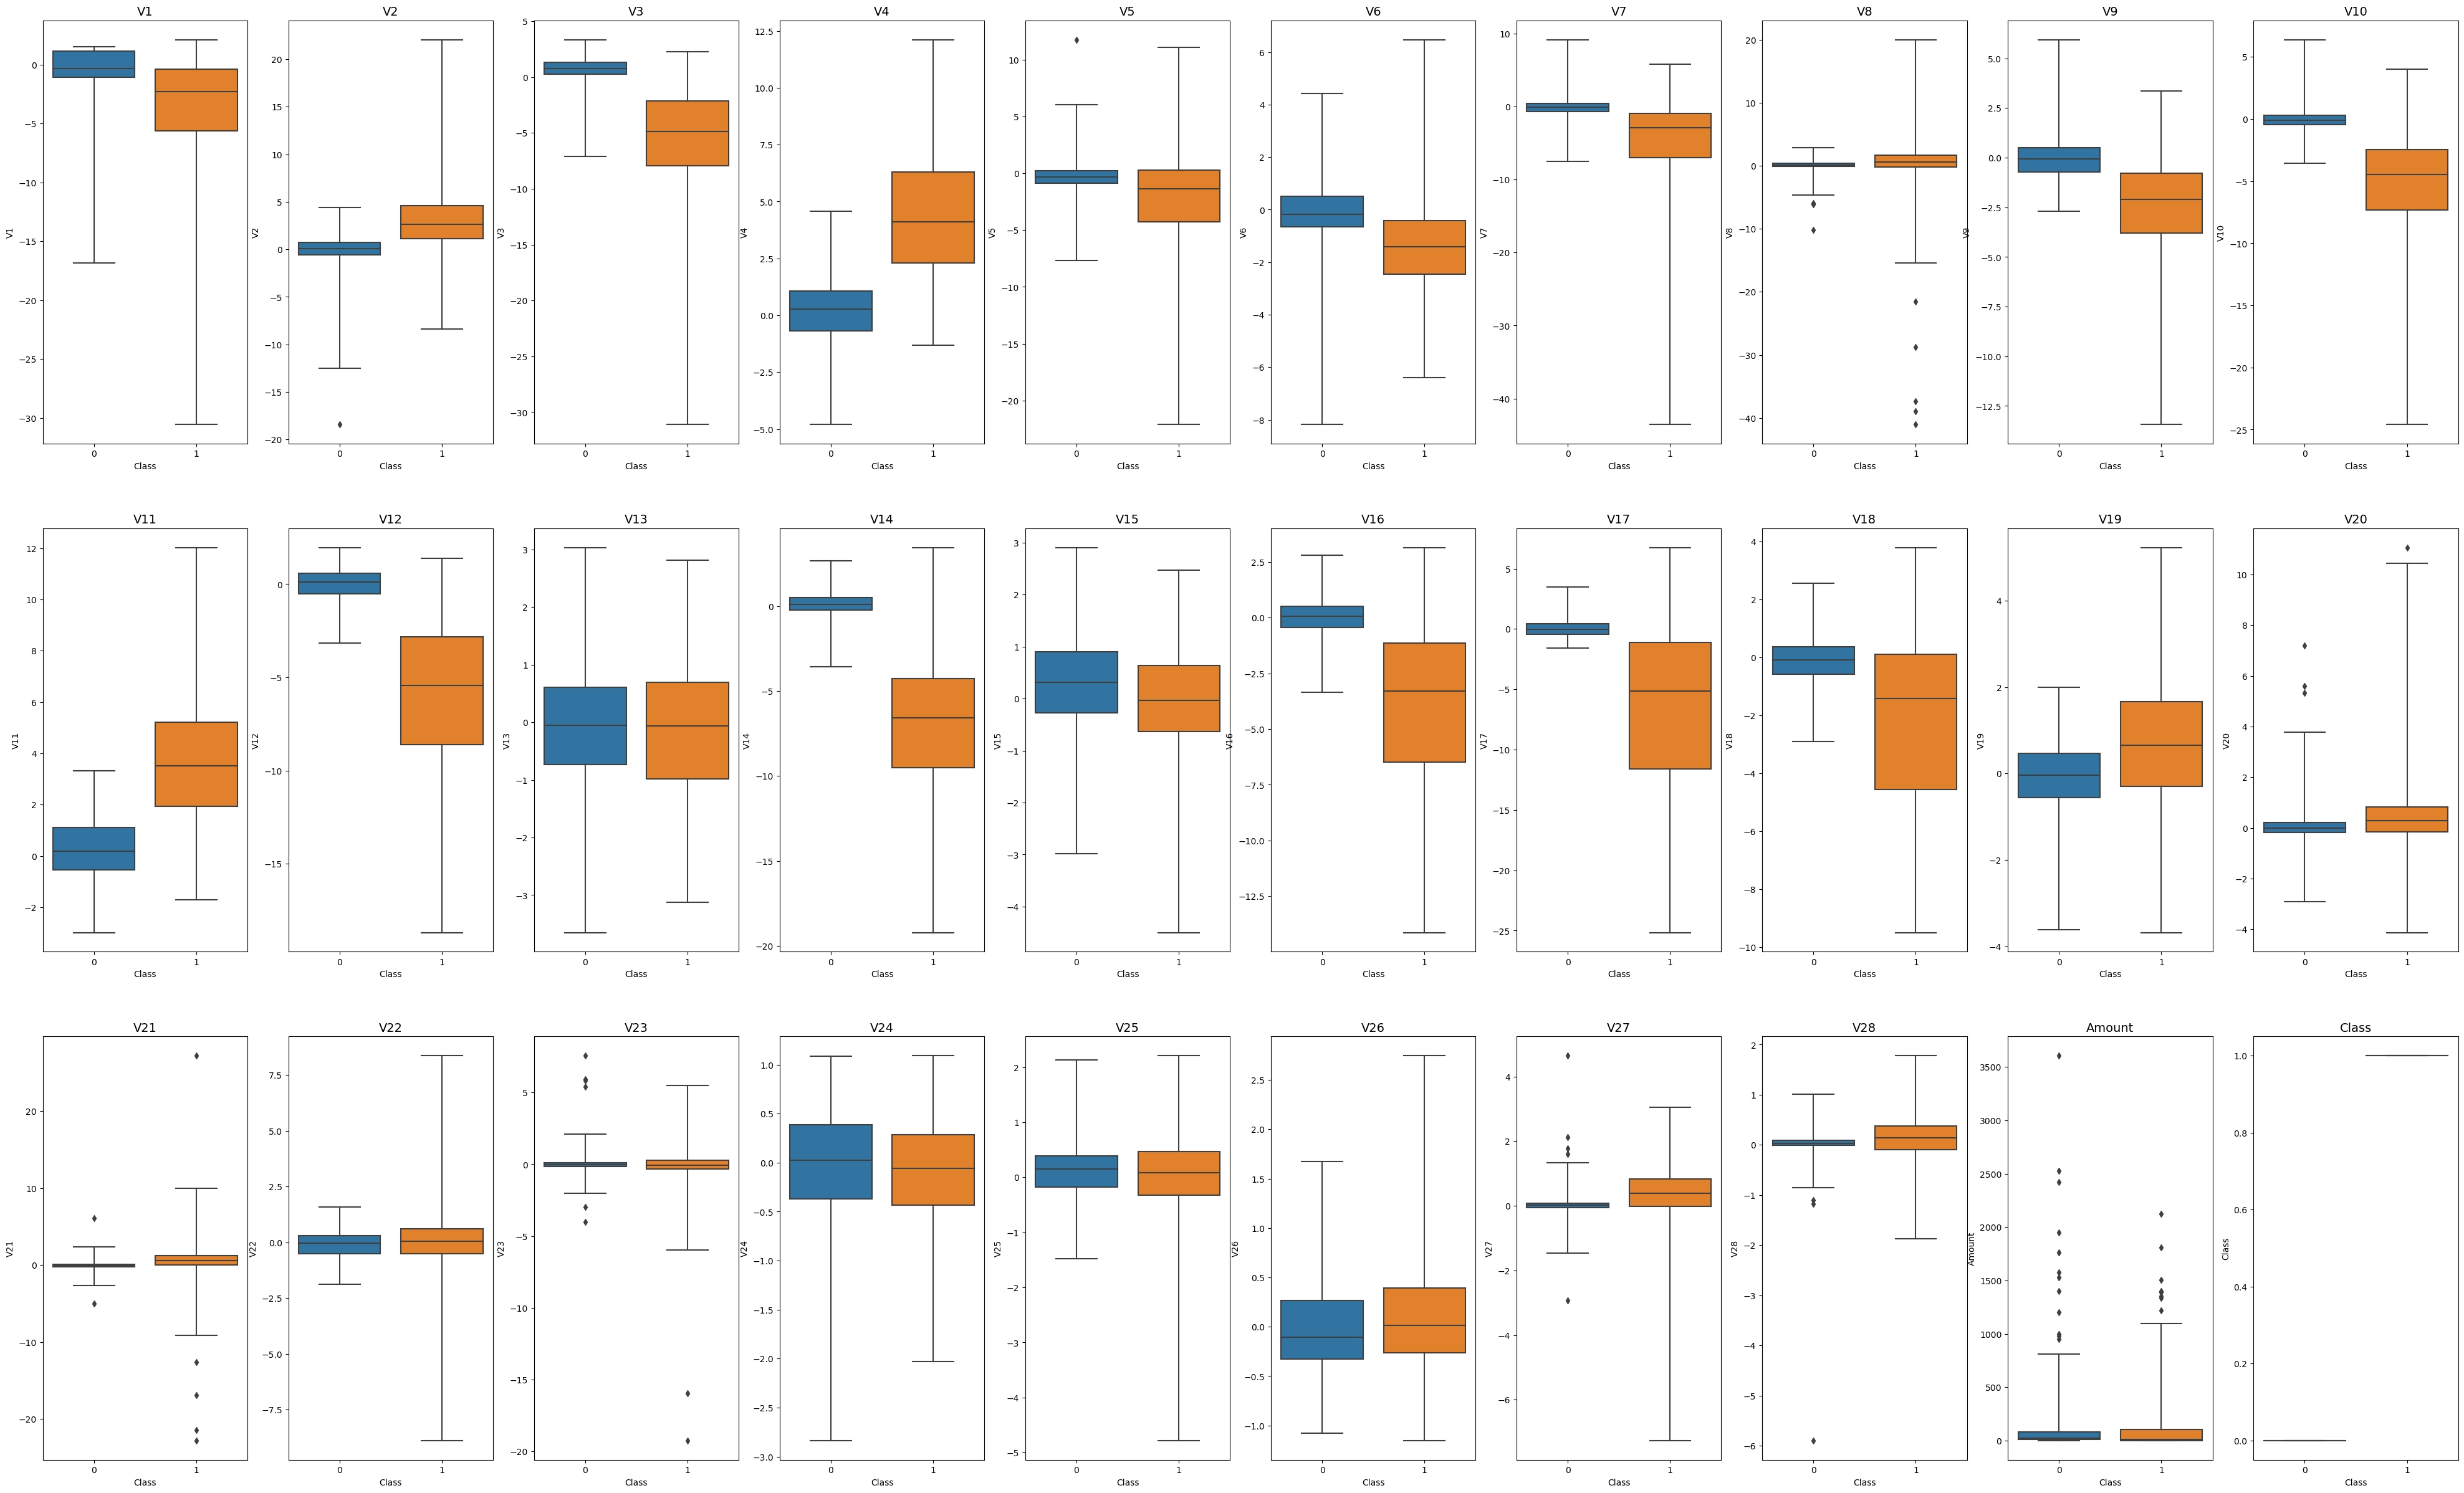

In [261]:
bounds={}
fig,ax=plt.subplots(3,10, figsize=(50,30))
i=0
for col in df_to_plot.columns:
    plt.title(col, size= 14)
    sns.boxplot(x='Class',y=col,data=df_to_plot.toPandas(),ax=ax[i//10][i%10],whis=10)
    ax[i//10][i%10].set_title(col, size= 14)
    i=i+1
    quantiles = df_to_plot.approxQuantile(col,[0.25,0.75],0.05)
    IQR = quantiles[1] - quantiles[0]
    bounds[col] = [quantiles[0] - 1.5*IQR,quantiles[1] + 1.5*IQR]
    
plt.show()

## With Correlation > 0.7

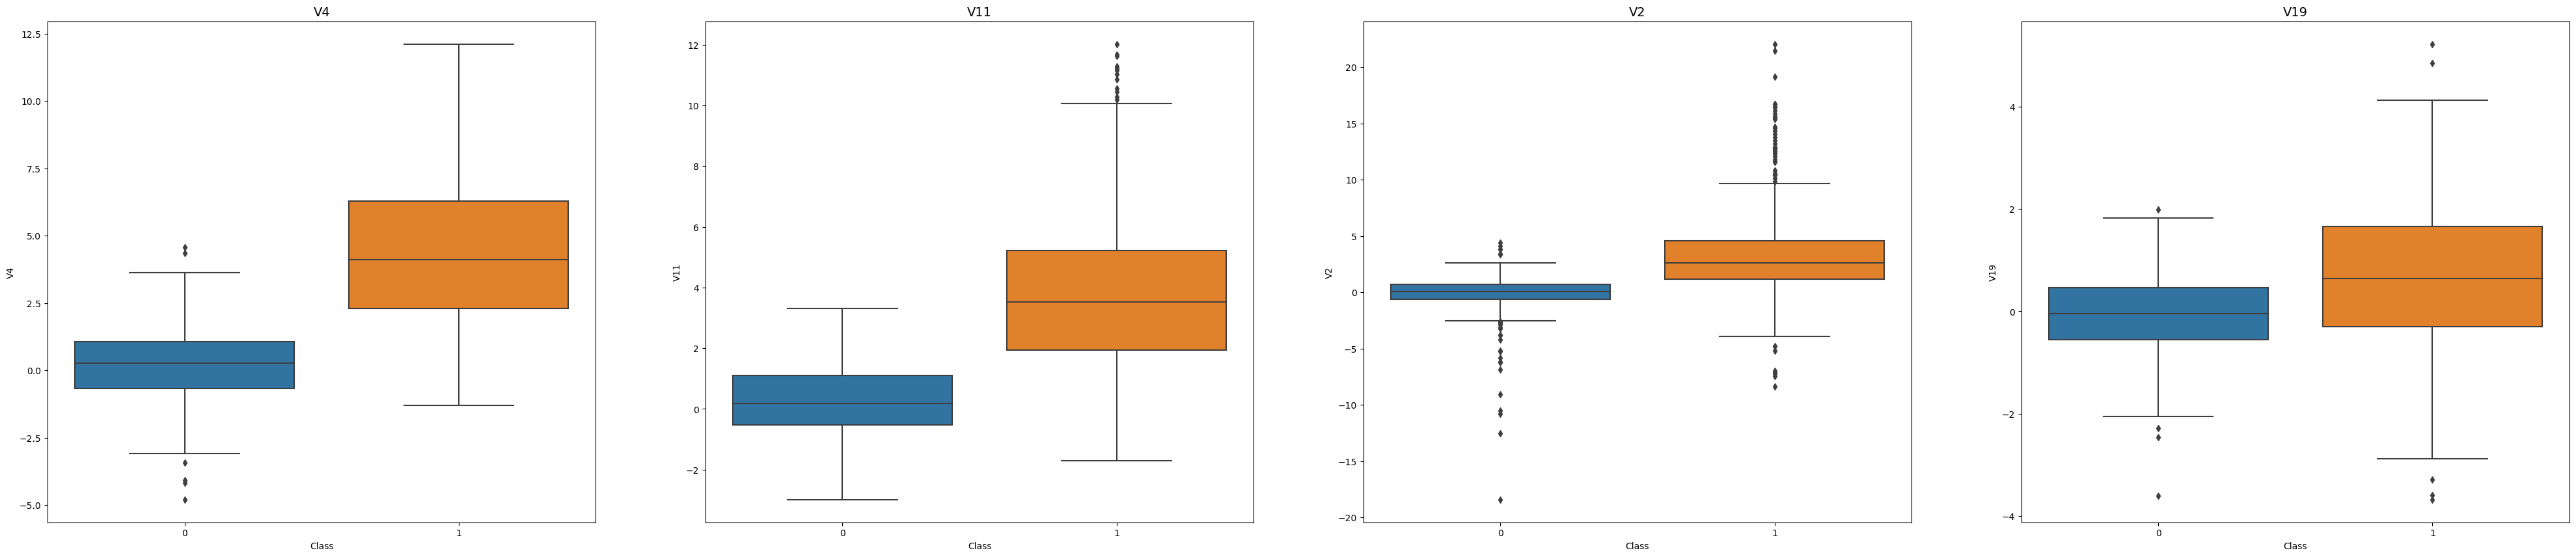

In [262]:
bounds={}
fig,ax=plt.subplots(1,4, figsize=(50,10))
i=0
for col in df_to_plot.select("V4", "V11", "V2", "V19").columns:
    plt.title(col, size= 14)
    sns.boxplot(x='Class',y=col,data=df_to_plot.toPandas(),ax=ax[i],whis=1.5)
    ax[i].set_title(col, size= 14)
    i=i+1
    quantiles = df_to_plot.approxQuantile(col,[0.25,0.75],0.05)
    IQR = quantiles[1] - quantiles[0]
    bounds[col] = [quantiles[0] - 1.5*IQR,quantiles[1] + 1.5*IQR]
    
plt.show()

## With Correlation <- 0.7

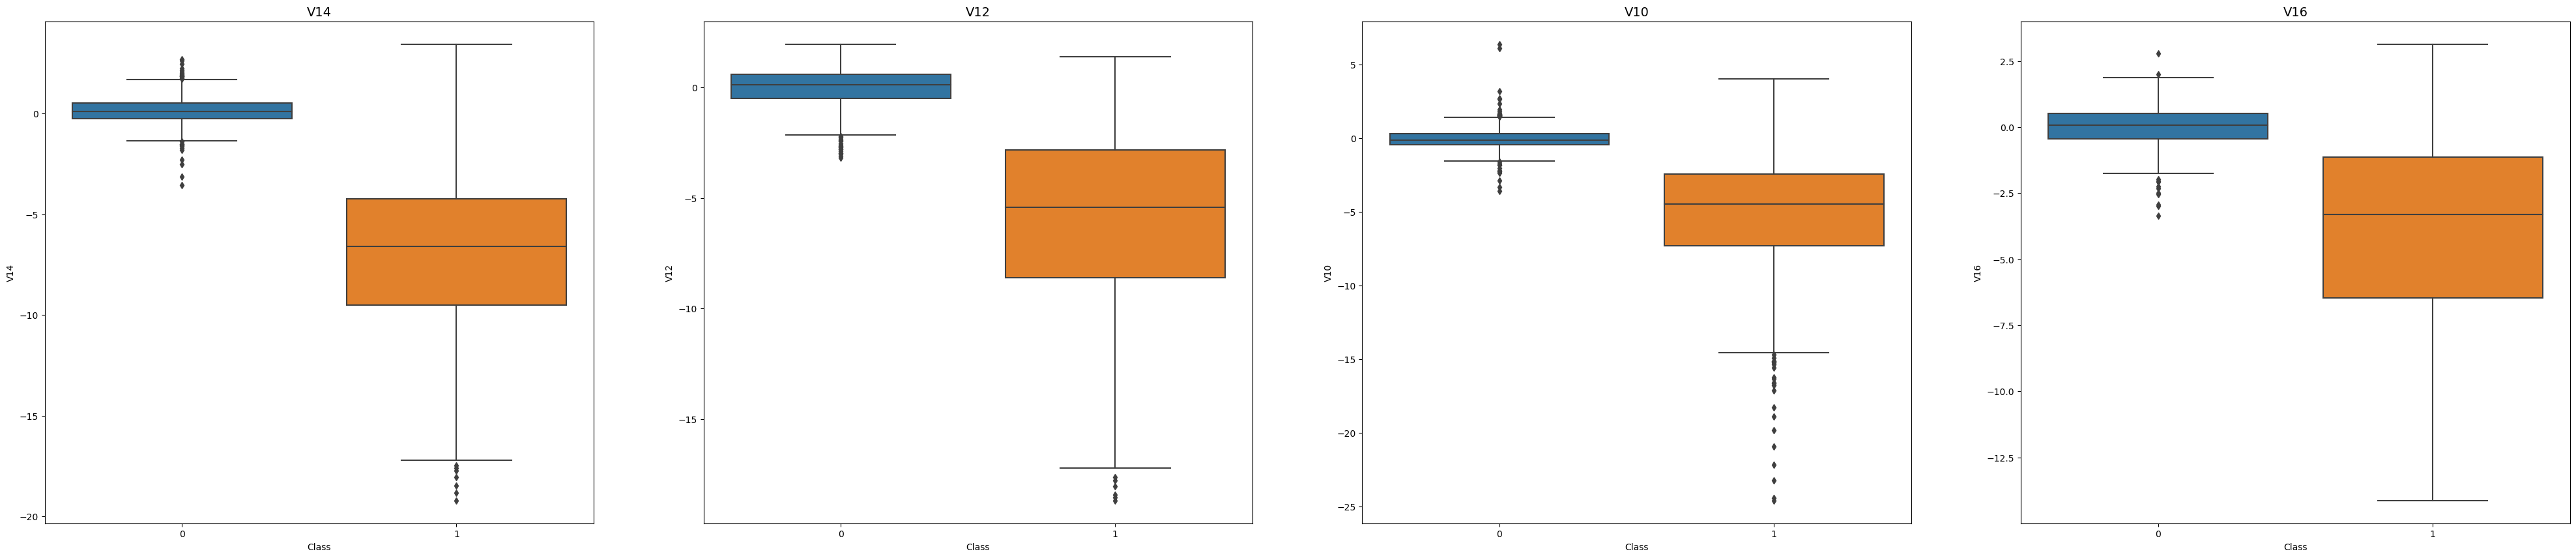

In [263]:
bounds={}
fig,ax=plt.subplots(1,4, figsize=(50,10))
i=0
for col in df_to_plot.select("V14", "V12", "V10", "V16").columns:
    plt.title(col, size= 14)
    sns.boxplot(x='Class',y=col,data=df_to_plot.toPandas(),ax=ax[i],whis=1.5)
    ax[i].set_title(col, size= 14)
    i=i+1
    quantiles = df_to_plot.approxQuantile(col,[0.25,0.75],0.05)
    IQR = quantiles[1] - quantiles[0]
    bounds[col] = [quantiles[0] - 1.5*IQR,quantiles[1] + 1.5*IQR]
    
plt.show()

## 2.0 Machine Learning Pipeline

Machine Learning Pipeline

The pipeline will involve the following models:

    Decision Tree
    Regression
    Random Forest
    Gradient-boosted trees
    Naive Bayes
    
How will this work? Here's our recipe for success:

    1st: load the data
    2nd: split the data (80/20 approach)
    3rd: get our feature columns and vectorize
    4th: instantiate Models
    5th: build and run the pipeline
    6th: apply metrics (we use accuracy, precision, recall and f1-score)

Documentation:

    https://spark.apache.org/docs/latest/ml-pipeline.html;
    https://spark.apache.org/docs/latest/ml-classification-regression.html#decision-tree-classifier
    https://www.v7labs.com/blog/f1-score-guide
    https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall
    https://datascience-enthusiast.com/Python/PySpark_ML_with_Text_part1.html

In [264]:
# Import libraries
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, GBTClassifier, LinearSVC, NaiveBayes
from pyspark.ml.feature import StringIndexer, VectorIndexer, IndexToString, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

In [265]:
# build a data split: 80/20
train, test = normal_distributed_df_shuffle.randomSplit(weights=[0.8, 0.2], seed=42)
print('Train shape: ', (train.count(), len(train.columns)))
print('Test shape: ', (test.count(), len(test.columns)))

Train shape:  (793, 31)
Test shape:  (153, 31)


In [266]:
# get feature columns names
feature_columns = [col for col in normal_distributed_df_shuffle.columns if col!= 'Class']
print(feature_columns)
print(len(feature_columns))

['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']
30


In [267]:
# vectorize
vectorizer = VectorAssembler(inputCols=feature_columns, outputCol="features")
train_vec = vectorizer.transform(train)
test_vec = vectorizer.transform(test)

In [268]:
train_vec.select('Time','Features','Class').show(10)

+------+--------------------+-----+
|  Time|            Features|Class|
+------+--------------------+-----+
|  26.0|[26.0,-0.52991228...|    0|
| 158.0|[158.0,-0.6008163...|    0|
| 265.0|[265.0,-0.4910030...|    0|
| 406.0|[406.0,-2.3122265...|    1|
| 459.0|[459.0,-0.5282175...|    0|
| 775.0|[775.0,-3.9008102...|    0|
| 943.0|[943.0,-1.2125020...|    0|
|1261.0|[1261.0,-0.883528...|    0|
|1293.0|[1293.0,-1.434347...|    0|
|1490.0|[1490.0,-0.798976...|    0|
+------+--------------------+-----+
only showing top 10 rows



In [269]:
# instantiate Models

# regression
lr = LogisticRegression(
    featuresCol='features',
    labelCol='Class',
    predictionCol='Class_Prediction',
    maxIter=10,
    regParam=0.3,
    elasticNetParam=0.8
)

# decison tree
dt = DecisionTreeClassifier(featuresCol='features',
    labelCol='Class',
    predictionCol='Class_Prediction'
)

# random forest
rf = RandomForestClassifier(
    featuresCol='features',
    labelCol='Class',
    predictionCol='Class_Prediction'
)

# gradient - boosted tree
gbt = GBTClassifier(
    featuresCol='features',
    labelCol='Class',
    predictionCol='Class_Prediction'
)

# linear support vector machines
lsvc = LinearSVC(
    featuresCol='features',
    labelCol='Class',
    predictionCol='Class_Prediction'
)

# naive bayes
#nb = NaiveBayes(
    #featuresCol='features',
    #labelCol='Class',
    #predictionCol='Class_Prediction'
    #smoothing=1.0, 
    #modelType="multinomial"
#)




# create list of models
list_of_models = [lr, dt, rf, gbt, lsvc]
list_of_model_names = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'Gradient-Boosted Tree', 'Linear Support Vector Machines']

# go through list
for model, model_name in zip(list_of_models, list_of_model_names):

    # print current model
    print('Current model: ', model_name)

    # create a pipeline object
    pipeline = Pipeline(stages=[model])

    # fit pipeline
    pipeline_model = pipeline.fit(train_vec)

    # get scores on the test set
    test_pred = pipeline_model.transform(test_vec)


    # get accuracy on test set
    accuracy_evaluator = MulticlassClassificationEvaluator(predictionCol='Class_Prediction', labelCol='Class', metricName='accuracy')
    accuracy_score = accuracy_evaluator.evaluate(test_pred)
    print('Accuracy: ', accuracy_score)

    # get precision on test set
    precision_evaluator = MulticlassClassificationEvaluator(predictionCol='Class_Prediction', labelCol='Class', metricName='precisionByLabel')
    precision_score = precision_evaluator.evaluate(test_pred)
    print('Precision: ', precision_score)

    # get recall on test set
    recall_evaluator = MulticlassClassificationEvaluator(predictionCol='Class_Prediction', labelCol='Class', metricName='recallByLabel')
    recall_score = recall_evaluator.evaluate(test_pred)
    print('Recall: ', recall_score)

    # get f1-score on test set
    f1_evaluator = MulticlassClassificationEvaluator(predictionCol='Class_Prediction', labelCol='Class', metricName='f1')
    f1_score = f1_evaluator.evaluate(test_pred)
    print('F1-score: ', f1_score)

Current model:  Logistic Regression
Accuracy:  0.9019607843137255
Precision:  0.8387096774193549
Recall:  1.0
F1-score:  0.9008141268203187
Current model:  Decision Tree
Accuracy:  0.9477124183006536
Precision:  0.9375
Recall:  0.9615384615384616
F1-score:  0.9476900578911003
Current model:  Random Forest
Accuracy:  0.9607843137254902
Precision:  0.9285714285714286
Recall:  1.0
F1-score:  0.9606935366739289
Current model:  Gradient-Boosted Tree
Accuracy:  0.9411764705882353
Precision:  0.9367088607594937
Recall:  0.9487179487179487
F1-score:  0.9411664122751652
Current model:  Linear Support Vector Machines
Accuracy:  0.954248366013072
Precision:  0.927710843373494
Recall:  0.9871794871794872
F1-score:  0.9541699738366112


As expected when working with an imbalanced, binary-targeted dataset, the predictions have excellent values for every metric. This happens because, in this particular case, 99% of records have a value of '0 - not fraud', which means that the model is basically training to predict 0s most of the time.

## 2.2 Feature Selection

## 2.3 Hyperparameter tuning with CrossValidator

In [270]:
from pyspark.ml.tuning import ParamGridBuilder,CrossValidator
rfparamGrid = (ParamGridBuilder()
               .addGrid(rf.maxDepth, [2, 4, 5])
               .addGrid(rf.numTrees, [5, 10, 20, 100])
             .build())

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluatorRF=BinaryClassificationEvaluator(labelCol='Class')

cv = CrossValidator(estimator = rf,
                      estimatorParamMaps = rfparamGrid,
                      evaluator = evaluatorRF,
                      numFolds = 5)

rfcv=cv.fit(test_pred)

## DESCONSIDERAR PARA BAIXO



In [68]:
#Normality checking
def is_normal(x, treshhold = 0.05):
    skew = x.select(f.skewness(x)).collect()[0][0]
    p = stats.skewtest(x.rdd.flatMap(lambda x: x).collect())[1]
    print(p)
    print(p > treshhold)
    print('\n')
    return p > treshhold

for name in df_to_plot.columns:
    is_normal(df_to_plot.select(name))

TypeError: Invalid argument, not a string or column: DataFrame[V1: double] of type <class 'pyspark.sql.dataframe.DataFrame'>. For column literals, use 'lit', 'array', 'struct' or 'create_map' function.

In [69]:
df_to_plot.columns

['V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V13',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V28',
 'Amount',
 'Class']

In [70]:
#Normality checking
def is_normal(x, treshhold = 0.05):
    k2,p = stats.normaltest(x)
    print(p)
    print(p > treshhold)
    print('\n')
    return p > treshhold

for name in list(new_df.loc[:, ~new_df.columns.isin(['Time','Class','IsFraud','time_udf'])]):
    is_normal(np.array(new_df[name]))

NameError: name 'new_df' is not defined

In [48]:
# Check skeness
# assuming `df` is your Spark DataFrame
skewness_values = {}

for col in df.columns:
    if col not in ['Time', 'Class', 'IsFraud', 'time_udf']:
        skewness_value = df_to_plot.select(f.skewness(col)).collect()[0][0]
        skewness_values[col] = skewness_value

print(skewness_values)

{'V1': -2.741171440276266, 'V2': 1.911370694077141, 'V3': -2.1177119362147554, 'V4': 0.9414235577781513, 'V5': -2.2886341509053727, 'V6': 0.38776306934327975, 'V7': -2.76921993098632, 'V8': -3.7027232290872854, 'V9': -1.52689654139133, 'V10': -1.7515213789324786, 'V11': 1.073410870338452, 'V12': -1.361245217556509, 'V13': -0.12837295804500773, 'V14': -1.047470534253667, 'V15': -0.6508529639405629, 'V16': -1.415750086758856, 'V17': -1.5152562764237723, 'V18': -1.3887877063514713, 'V19': 0.458759971664903, 'V20': 2.9849476270490087, 'V21': 3.9041275336946977, 'V22': -1.5744483205910864, 'V23': -6.985279507024805, 'V24': -0.5201018681909418, 'V25': -0.9387244257920794, 'V26': 0.8120465901521634, 'V27': -2.6965532965028207, 'V28': -0.8698621279224755, 'Amount': 6.725854602643324}


In [ ]:
# Visualization of the relation between each variable and Class
x = 0
plt.figure(figsize = [18,20]);
for i in new_df.loc[:, ~new_df.columns.isin(['Time','Class','IsFraud','time_udf'])] :
    plt.subplot(8,4,x+1)
    sns.boxplot(data = new_df, x = 'Class', y = i)
    plt.title("barplot visualization between Class and {}".format(i), size = 12);
    x = x +1
    plt.subplots_adjust(left=0.1, 
                    bottom=0.1,  
                    right=0.9,  
                    top=0.9,  
                    wspace=0.3,  
                    hspace=0.5) 
plt.show()

In [ ]:
print('Sorted Correlation values with Class:')
print(new_df1[new_df1.columns[1:]].corr()['Class'][:-1].sort_values())

In [ ]:
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
from collections import OrderedDict
corrs = OrderedDict([(col, pearsonr(new_df1[col], new_df1['Class'] == 1)) for col in new_df1.loc[:, ~new_df1.columns.isin(['Time','Class'])]])
corrs = pd.DataFrame(index = corrs.keys(), data={
        'corr_coef': [corr[0] for corr in corrs.values()],
        'p_value': [corr[1] for corr in corrs.values()],
    })

corrs.applymap(lambda xx : abs(xx)).sort_values(by='corr_coef', ascending=False).rename(columns={
        'corr_coef': 'absolute correlation coefficient'
    })

In [ ]:
#Histogram distribution if is Fraud
new_df1.loc[:, ~new_df1.columns.isin(['Time','Class'])].loc[new_df['Class'] == 1].hist(bins=30, figsize=(10, 10))
plt.subplots_adjust(left=0.1, 
                    bottom=0.1,  
                    right=0.9,  
                    top=0.9,  
                    wspace=0.4,  
                    hspace=0.8) 
plt.show()

In [ ]:
from scipy.stats import norm

f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20, 6))

v14_fraud_dist = new_df1['V14'].loc[new_df1['Class'] == 1].values
sns.distplot(v14_fraud_dist,ax=ax1, fit=norm, color='#FB8861')
ax1.set_title('V14 Distribution \n (Fraud Transactions)', fontsize=14)

v12_fraud_dist = new_df1['V12'].loc[new_df1['Class'] == 1].values
sns.distplot(v12_fraud_dist,ax=ax2, fit=norm, color='#56F9BB')
ax2.set_title('V12 Distribution \n (Fraud Transactions)', fontsize=14)


v10_fraud_dist = new_df1['V10'].loc[new_df1['Class'] == 1].values
sns.distplot(v10_fraud_dist,ax=ax3, fit=norm, color='#C5B3F9')
ax3.set_title('V10 Distribution \n (Fraud Transactions)', fontsize=14)

plt.show()

In [ ]:
for i in new_df1.columns:
    plt.figure();
    plt.tight_layout()
    sns.set(rc={"figure.figsize":(8, 5)})
    f, (ax_hist) = plt.subplots(1, sharex=True)
    plt.gca().set(xlabel= i,ylabel='Density')
    #sns.histplot(new_df[i], ax=ax_hist ,  bins = 20, kde=True)
    sns.distplot(new_df1[i], ax=ax_hist, fit=norm, color='#FB8861')

#plt.show()

## Outliers

In [ ]:
z = np.abs(stats.zscore(new_df1.loc[:, ~new_df1.columns.isin(['Time','Class'])]))
threshold = 3
df1_new = new_df1[(z < 3).all(axis=1)]

df1_new.describe().T 

In [ ]:
new_df1.loc[:, ~new_df1.columns.isin(['Amount','Time','Class', 'IsFraud','time_udf'])].boxplot( figsize=(12,8), vert=False)
plt.title("With outliers", fontsize=14)
plt.show()

In [ ]:
df1_new.loc[:, ~df1_new.columns.isin(['Amount','Time','Class'])].boxplot( figsize=(12,8), vert=False)
plt.title("Without outliers", fontsize=14)
plt.show()

In [ ]:
# % of data removed :
print("percentage of records removed is :",(1 - (df1_new.shape[0] / new_df1.shape[0]))*100,", it is an accepted % ")

In [ ]:
#Plot Distribution of the Classes
print('Distribution of the Classes in the dataset without outliers')
print(df1_new['Class'].value_counts()/len(df1_new))

sns.countplot(x ='Class', data=df1_new)
plt.title('Balanced Classes without outliers', fontsize=14)
plt.show()

In [ ]:
# Visualization of the relation between each variable and Class in a balanced dataset without outliers
x = 0
plt.figure(figsize = [18,20]);
for i in df1_new.loc[:, ~df1_new.columns.isin(['Time','Class'])] :
    plt.subplot(8,4,x+1)
    sns.boxplot(data = df1_new, x = 'Class', y = i)
    plt.title("barplot visualization between Class and {}".format(i), size = 12);
    x = x +1
    plt.subplots_adjust(left=0.1, 
                    bottom=0.1,  
                    right=0.9,  
                    top=0.9,  
                    wspace=0.3,  
                    hspace=0.5) 
plt.show()

In [ ]:
f,(ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,6))
colors = ['#B3F9C5', '#f9c5b3']
# Boxplots with outliers removed
# Feature V14
sns.boxplot(x="Class", y="V14", data=df1_new,ax=ax1, palette=colors)
ax1.set_title("V14 Feature \n Reduction of outliers", fontsize=14)
ax1.annotate('Fewer extreme \n outliers', xy=(0.98, -17.5), xytext=(0, -12),
             arrowprops=dict(facecolor='black'),
             fontsize=14)
# Feature 12
sns.boxplot(x="Class", y="V12", data=df1_new, ax=ax2, palette=colors)
ax2.set_title("V12 Feature \n Reduction of outliers", fontsize=14)
ax2.annotate('Fewer extreme \n outliers', xy=(0.98, -17.3), xytext=(0, -12),
             arrowprops=dict(facecolor='black'),
             fontsize=14)
# Feature V10
sns.boxplot(x="Class", y="V10", data=df1_new, ax=ax3, palette=colors)
ax3.set_title("V10 Feature \n Reduction of outliers", fontsize=14)
ax3.annotate('Fewer extreme \n outliers', xy=(0.95, -16.5), xytext=(0, -12),
             arrowprops=dict(facecolor='black'),
             fontsize=14)
plt.show()

## Machine Learning - É PRECISO REVER TUDO DAQUI PARA BAIXO

In [ ]:
# Importing required Spark ML lib methods

from pyspark.ml import Pipeline
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.feature import VectorIndexer, VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.linalg import DenseVector

In [ ]:
dfsp = spark.createDataFrame(new_df.loc[:, ~new_df.columns.isin(['IsFraud','time_udf'])])


In [ ]:
# Converting String data type of column to double

for column in dfsp.columns:
    data = dfsp.withColumn(column,dfsp[column].cast("double"))

In [ ]:
#Adding index to keep track of the rows even after shuffling

from pyspark.sql.functions import *
from pyspark.sql.window import Window
win = Window().orderBy('Time')
dfsp = dfsp.withColumn("idx", row_number().over(win))

In [ ]:
dfsp.head()

In [ ]:
feature_columns = [col for col in dfsp.columns if col.startswith("V")]
print(feature_columns)

In [ ]:
vectorizer = VectorAssembler(inputCols = feature_columns, outputCol="features")
vectorizer.transform(df).select("features", "Class").limit(5).toPandas()

In [ ]:
est = RandomForestClassifier()
est.setMaxDepth(5)
est.setLabelCol("Class")

In [ ]:
print(est.explainParams())

In [ ]:
# Importing required Spark ML lib methods

from pyspark.ml.pipeline import Pipeline, PipelineModel
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.feature import VectorIndexer, VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.linalg import DenseVector

In [ ]:
# Converting the feature columns to dense vector (required by spark) and creating label and index columns

training_df = dfsp.rdd.map(lambda x: (DenseVector(x[0:29]),x[30],x[31]))

In [ ]:
training_df = spark.createDataFrame(training_df,["features","label","index"])

In [ ]:
training_df = training_df.select("index","features","label")

In [ ]:
# Splitting data into training and testing data

train_data, test_data = training_df.randomSplit([.8,.2],seed=1234)

In [ ]:
train_data.groupBy("label").count().show()

In [ ]:
test_data.groupBy("label").count().show()

In [ ]:
df_train, df_test = df.randomSplit(weights=[0.7, 0.3], seed = 1)

In [ ]:
pipeline = Pipeline()
pipeline.setStages([vectorizer, est])
model = pipeline.fit(df_train)

In [ ]:

df_test_pred = model.transform(df_test)

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [ ]:
evaluator = BinaryClassificationEvaluator()
evaluator.setLabelCol("Class")

In [ ]:
evaluator.evaluate(model.transform(df_test))

In [ ]:
from pyspark.sql.functions import *

In [ ]:
test_accuracy = (df_test_pred
                 .select("Class", "prediction")
                 .withColumn("isEqual", expr("Class == prediction"))
                 .select(avg(expr("cast(isEqual as float)")))
                 .first())

In [ ]:
test_accuracy

In [ ]:
treeEstimator = DecisionTreeClassifier()
treeEstimator.setImpurity("entropy")
treeEstimator.setLabelCol("Class")

pipeline = Pipeline()
pipeline.setStages([vectorizer, treeEstimator])
model = pipeline.fit(df_train)
evaluator.evaluate(model.transform(df_test))

In [ ]:
accuracy_evaluator = MulticlassClassificationEvaluator()
accuracy_evaluator.setLabelCol("Class")
accuracy_evaluator.setMetricName("accuracy")
accuracy_evaluator.evaluate(model.transform(df_test))

In [ ]:
f1_evaluator = MulticlassClassificationEvaluator()
f1_evaluator.setLabelCol("Class")
f1_evaluator.setMetricName("f1")
f1_evaluator.evaluate(model.transform(df_test))

## Gradient Boosting Trees Classifier Model

In [ ]:
# Creating Gradient Boosting Trees Classifier Model to fit and predict data

gbt = GBTClassifier(featuresCol="features", maxIter=100,maxDepth=8)
model = gbt.fit(train_data)
predictions = model.transform(test_data)

In [ ]:
# Checking the count of records classified into each classes

predictions.groupBy("prediction").count().show()

In [ ]:
# Calculating accuracy of model

evaluator = BinaryClassificationEvaluator()
evaluator.evaluate(predictions)

In [ ]:
# Calculating percentage of fraud records predicted correctly

predictions = predictions.withColumn("fraudPrediction",when((predictions.label==1)&(predictions.prediction==1),1).otherwise(0))
predictions.groupBy("fraudPrediction").count().show()

In [ ]:
predictions.groupBy("label").count().show()

In [ ]:
accurateFraud = predictions.groupBy("fraudPrediction").count().where(predictions.fraudPrediction==1).head()[1]
totalFraud = predictions.groupBy("label").count().where(predictions.label==1).head()[1]
FraudPredictionAccuracy = (accurateFraud/totalFraud)*100
print("Fraud Prediction Accuracy: ",FraudPredictionAccuracy)

In [ ]:
# Calculating Confusion matrix

tp = predictions[(predictions.label == 1) & (predictions.prediction == 1)].count()
tn = predictions[(predictions.label == 0) & (predictions.prediction == 0)].count()
fp = predictions[(predictions.label == 0) & (predictions.prediction == 1)].count()
fn = predictions[(predictions.label == 1) & (predictions.prediction == 0)].count()
print("True Positive: ",tp,"\nTrue Negative: ",tn,"\nFalse Positive: ",fp,"\nFalse Negative: ",fn)
print("Recall: ",tp/(tp+fn))
print("Precision: ", tp/(tp+fp))
print("F1 Score",  (2 * (tp/(tp+fp)) * (tp/(tp+fn)) /((tp/(tp+fp)) + (tp/(tp+fn)))))